In [ ]:
#Preloader
#Create a class that takes as input the type of measurement to be used "VHR" , "VLR"
import pandas as pd
import numpy as np
import os
        
    
class PreLoader:
    """Handles files loading and datasets preparation to get passed into the DataPreparation class"""
    parent_folder = r"/kaggle/input/datasetsnew/datasets"
    def __init__(self, type):
        self.type = type
        if self.type == "vhr":
            self.df = pd.read_csv(r"/kaggle/input/datasetsnew/datasets/vhr/metadata.csv")
        
        elif self.type == "vlr":
            self.df = pd.read_csv(r"/kaggle/input/datasetsnew/datasets/vlr/metadata.csv")
            
        elif self.type == "both":
            df_hr = pd.read_csv(r"/kaggle/input/datasetsnew/datasets/vhr/metadata.csv")
            df_lr = pd.read_csv(r"/kaggle/input/datasetsnew/datasetsvlr/metadata.csv")
            self.df = pd.concat([df_hr, df_lr]).reset_index(drop=True)

        else:
            raise Exception ("undefined measurement type")
        
        #Eval columns
        self.df["standardized_faults"] = self.df["standardized_faults"].apply(lambda x: eval(x))
        self.df["rpm"] = self.df["rpm"].apply(lambda x: eval(x))
        self.df["bearing_abbs"] = self.df["bearing_abbs"].apply(lambda x: eval(x))

        #Standardize status
        self.df["status"] = self.df["status"].apply(lambda x: x.strip())

        #Flatten faults
        self.df["standardized_faults"] = self.df["standardized_faults"].apply(lambda xss: [x for xs in xss for x in xs])
        self.df["standardized_faults"] = self.df["standardized_faults"].apply(lambda x: [fault for fault in x if fault != ""])
        self.df["standardized_faults"] = self.df["standardized_faults"].apply(lambda x: [fault for fault in x if fault != "NAF"])
        self.df["standardized_faults"] = self.df["standardized_faults"].apply(lambda lst: [','.join(y.split(',')[:2]) for y in lst])

        #Sort out speeds
        self.df["rpm"] = self.df["rpm"].explode().apply(lambda x: x.replace("rpm", "").replace(",", "").strip())
        self.df["rpm"] = self.df["rpm"].apply(lambda x: float(x))

        
    def sort_dict(ts_path_dictionary):
        return dict(sorted(ts_path_dictionary.items(), reverse=False))
        
    def get_ts_files_paths(self):
        """Returns a list of paths (ts, metadata)"""
        ts_files_paths = {}
        for filename in os.listdir(PreLoader.parent_folder):
            if self.type in filename:
                folder_to_loop_inside = os.path.join(PreLoader.parent_folder, filename)
                for filename in os.listdir(folder_to_loop_inside):
                    if "metadata" in filename:
                        continue
                    file_bearing_index = int(filename.split('.')[0])
                    ts_files_paths[file_bearing_index] = os.path.join(folder_to_loop_inside, filename)
                    
                break

        ts_files_paths = PreLoader.sort_dict(ts_path_dictionary=ts_files_paths)
        return ts_files_paths
    

    def get_3d_ts_array(self):
        """Returns a 3D time series array"""
        ts_file_paths = PreLoader.get_ts_files_paths(self).values()
        ts_list = []
        bearing_all_ts = [np.array(pd.read_csv(path)) for path in ts_file_paths]
        for i in range(len(self.df)):
            sample_ts = np.array([arr[i] for arr in bearing_all_ts])
            ts_list.append(sample_ts)

        return np.array(ts_list)
        
    def get_labels_array(self, labels_type):
        if labels_type == "faults":
            return np.array(self.df["standardized_faults"])
        elif labels_type == "status":
            return np.array(self.df["status"])
        else:
            raise Exception ("Invalid labels type, chooise between faults and status")
    
        
    def set_faults_as_one(self, faults_to_combine, target_fault):
        for index, row in self.df.iterrows():
            old_faults_list = row["standardized_faults"]
            new_temp_faults_list = []
            for old_fault in old_faults_list:
                if any(fault_to_combine in old_fault for fault_to_combine in faults_to_combine):
                    new_fault = target_fault + "," + old_fault.split(',')[1]
                    new_temp_faults_list.append(new_fault)
                else:
                    new_temp_faults_list.append(old_fault)
            self.df.at[index, "standardized_faults"] = new_temp_faults_list

In [45]:
# ArrayGenerator
import numpy as np

class ArrayGenerator:
    dataset_categories = {
        1 : "motor",        # Classifying motor faults                          (binary)
        2 : "bearing",      # Classifying bearing faults                        (binary)
        3 : "flow",         # Classifying flow faults                           (binary)
        4 : "lxc",          # Claasifying LXC faults                            (binary)
        5 : "mixed",        # Classifying LXC, Unbalance, and Base problems     (multiclass multilabel)
        6 : "coupling",     # Classifying coupling related faults               (binary)
        7 : "all",          # Classifying all of the above                      (multiclass multilabel)
        8 : "status"        # Classifying status                                (multiclass)
    }
    
    dataset_descriptions = {
        1 : {"Faults classified" : "AirGap, Electrical and SoftFoot problems", "Channels taken" : "Motor channels only", "Labels array" : "Binary"},
        2 : {"Faults classified" : "BearingFault, BearingWear, BearingLubrication", "Channels taken" : "According to label", "Labels array" : "Binary"},
        3 : {"Faults classified" : "Flow problem", "Channels taken" : "Machine channels only", "Labels array" : "Binary"},
        4 : {"Faults classified" : "LXC, XC, Losseness", "Channels taken" : "All", "Labels array" : "Binary"},
        5 : {"Faults classified" : "LXC, Unbalance, BaseProblems", "Channels taken" : "All", "Labels array" : "multiclass multilabel"},
        6 : {"Faults classified" : "Coupling problems", "Channels taken" : "Drive end channels only", "Labels array" : "Binary"},
        7 : {"Faults classified" : "All", "Channels taken" : "All", "Labels array" : "multiclass multilabel"},
        8 : {"Faults classified" : "Status", "Channels taken" : "All", "Labels array" : "multiclass"}
    }

    def separate_data(ts, labels, split_method):
        """
        A function that separates the ts arrays by channel, bearing, machine or none.
        Args:
            ts: 3D numpy array of time series data,
            labels: Associated labels
            by: split method (Options: channel, bearing, machine, none)
        Returns:
            A tuple of new split 3D array and their associated labels.
        """
        _, num_channels, num_points = ts.shape
        
        if split_method == "channel":
            new_ts = ts.reshape(-1, 1, num_points)
            new_labels = np.repeat(labels, repeats=num_channels, axis=0)
        elif split_method == "bearing":
            new_ts = ts.reshape(-1, 3, num_points)
            new_labels = np.repeat(labels, repeats=num_channels // 3, axis=0)
        elif split_method == "machine":
            new_ts = ts.reshape(-1, 6, num_points)
            new_labels = np.repeat(labels, repeats=num_channels // 6, axis=0)
        elif split_method is None:
            new_ts = ts
            new_labels = np.array(labels)
        else:
            raise Exception ("Invalid split type: choose from [channel, bearing, machine, None]")
        
        return new_ts, new_labels

    def generate_dataset_array(dataset_category, ts, labels, split_method):
        """
        A function that generates the 3D time series arrays and their associated labels for the dataset categories described above.
        Args:
            dataset_category: int (from 1 to 7)
            ts: 3D time series array
            labels: the associated labels
            split_method: the method to split the data by (channel, bearing, machine, or None)
        
        Returns:
            A tuple of new 3D time series array and their associated labels
        """
        if dataset_category == 1: 
            faults = ["AirGap", "SoftFoot", "ElectricalProblem"]
            new_labels = [1 if any(motor_fault in fault for fault in faults_list for motor_fault in faults) else 0 for faults_list in labels]
            new_ts = ts[:, :6, :]
        elif dataset_category == 2:
            faults = ["BearingFault", "BearingWear", "BearingLubrication"]
            new_labels = np.zeros((len(labels), 2))

            for major_index, faults_list in enumerate(labels):
                for fault in faults_list:
                    fault_name, fault_location = fault.split(',')
                    if any(bearing_fault == fault_name for bearing_fault in faults):
                        if fault_location == "motor":
                            new_labels[major_index][0] = 1
                        else:
                            new_labels[major_index][1] = 1
            new_ts_1 = ts[:, :6, :]
            new_labels_1 = new_labels[:, 0]

            new_ts_2 = ts[:, 6:, :]
            new_labels_2 = new_labels[:, 1]
            
            new_labels = np.concatenate([new_labels_1, new_labels_2], axis=0)
            new_ts = np.concatenate([new_ts_1, new_ts_2], axis=0)
            
        elif dataset_category == 3:
            faults = ["Flow"]
            new_labels = [1 if any(flow_fault in fault for fault in faults_list for flow_fault in faults) else 0 for faults_list in labels]
            new_ts = ts[:, 6:, :]
            
        elif dataset_category == 4:
            faults = ["LXC", "Looseness", "XC"]
            new_labels = [1 if any(lxc_fault in fault for fault in faults_list for lxc_fault in faults) else 0 for faults_list in labels]
            new_ts = ts
            
        elif dataset_category == 5:
            faults_and_indices = {
                0 : ["LXC", "Looseness", "XC"],
                1 : ["BaseProblems"],
                2 : ["Unbalance"]
            }
            
            new_labels = np.zeros((len(labels), 3))
            for major_index, faults_list in enumerate(labels):
                for fault in faults_list:
                    fault_name, fault_location = fault.split(',')
                    for index, fault_names in faults_and_indices.items():
                        if fault_name in fault_names:
                            new_labels[major_index][index] = 1
            new_ts = ts
            
        elif dataset_category == 6:
            faults = ["Coupling", "BeltProblem"]
            new_labels = [1 if any(coupling_fault in fault for fault in faults_list for coupling_fault in faults) else 0 for faults_list in labels]
            new_ts = ts[:, 3:9, :]
            
        elif dataset_category == 7:
            faults_and_indices = {
                0 : ["AirGap", "SoftFoot", "ElectricalProblem"],
                1 : ["BearingFault", "BearingWear", "BearingLubrication"],
                2 : ["flow"],
                3 : ["LXC", "Looseness", "XC"],
                4 : ["BaseProblems"],
                5 : ["Unbalance"],
                6 : ["Coupling", "BeltProblem"]
            } 
            
            new_labels = np.zeros((len(labels), 7))
            for major_index, faults_list in enumerate(labels):
                for fault in faults_list:
                    fault_name, fault_location = fault.split(',')
                    for index, fault_cluster in faults_and_indices.items():
                        if fault_name in fault_cluster:
                            new_labels[major_index][index] = 1
            new_ts = ts
            
        elif dataset_category == 8:
            if type(labels[0]) == list:
                raise Exception ("Invalid labels for cateogry 8")
                new_ts = ts
                new_labels = labels
        else:
            raise Exception ("Invalid dataset category, choose from [1, 2, 3, 4, 5, 6, 7]")
        
        print(ArrayGenerator.dataset_descriptions[dataset_category])  # Corrected line
        return ArrayGenerator.separate_data(ts=new_ts, labels=new_labels, split_method=split_method)

    def calculate_fft(signal):
        """Calculates the FFT for a single channeled time series.
            Used with apply_along_axis when applied to a two dimensional series.
        Args:
            signal: a numpy array time series signal (single channel)
        Returns:
            A numpy array containing the fft with length equal to half the length
            of the input time series array."""
        signal = signal * np.hanning(len(signal)) # Apply hanning window
        fft = np.fft.fft(signal)
        fft = np.abs(fft) # Take absolute value
        fft = fft[: len(fft) // 2] # Take the first half only
        return fft

    def apply_sliding_window(ts_3d, labels, window_size=1024, overlap_pct=0.1, with_fft=False):
        """Applies the sliding window on the ts 3d array and its associated labels.
        
        Args:
            ts_3d: 3d time series array
            labels: associated labels
            window_size: int, window size
            overlap_pct: float, overlap percentage between (0, 1)
            with_fft: boolean, applies the fft function
        Returns:
            a tuple of new windowed 3d times series array and its associated labels"""
        x_new = []
        y_new = []
        
        for ts, label in zip(ts_3d, labels):
            ts = ts[:, ~np.any(np.isnan(ts), axis=0)]
            num_channels, signal_length = ts.shape
            overlap = int(window_size * overlap_pct)
            stride = window_size - overlap
            num_windows = (signal_length - window_size) // stride + 1

            if with_fft == True:
                x_temp = np.zeros((num_windows, num_channels, window_size // 2))
            else:
                x_temp = np.zeros((num_windows, num_channels, window_size))
            
            y_temp = []

            for i in range(num_windows):
                start = i * stride
                end = start + window_size
                if with_fft == True:
                    x_temp[i] = np.apply_along_axis(calculate_fft, arr=ts[:, start:end], axis=1) 
                else:
                    x_temp[i] = ts[:, start:end]
                y_temp.append(label)

            x_new.append(x_temp)
            y_new.append(y_temp)

        x_new, y_new = np.concatenate(x_new), np.concatenate(y_new)

        return x_new, y_new


In [46]:
# Initialize a preloader object with the range required
preloader = PreLoader("vhr") # Pass "vlr" or "vhr" or "both".
# To take a look at the dataframe
preloader.df.head()

,name,date,status,rpm,bearing_abbs,standardized_faults,report_name,zone,area,factory,type,ts_shape_no_nans
0,Main Fan A(F-005A),2022-01-20,hmv,1476.6,{},"[Misalignment,machine, SoftFoot,motor, BaseProblems,motor, BaseProblems,motor, BeltProblem,machine, BaseProblems,machine, CockedBearing,machine, Looseness,machine, Misalignment,machine, XC,machine, BaseProblems,motor, SoftFoot,motor]",RTC220055-9004934-Line 4-F-005A-V001-D-36-3101-22-6144.docx,AZFC Zone 4,New Numan Mill,AZFC,vhr,"(12, 8192)"
1,Main Fan A(F-005A),2022-05-16,hmv,1488.0,{},"[Misalignment,machine, SoftFoot,motor, BaseProblems,motor, BaseProblems,motor, BeltProblem,machine, BaseProblems,machine, CockedBearing,machine, Looseness,machine, Misalignment,machine, XC,machine, BaseProblems,motor, SoftFoot,motor]",RTC220340-Line 4-F-005A-V001-D-36-2205-22-6527.docx,AZFC Zone 4,New Numan Mill,AZFC,vhr,"(12, 8192)"
2,Main Fan A(F-005A),2022-06-19,hmv,1486.2,{},"[Misalignment,machine, SoftFoot,motor, BaseProblems,motor, BaseProblems,motor, BeltProblem,machine, BaseProblems,machine, CockedBearing,machine, Looseness,machine, Misalignment,machine, XC,machine, BaseProblems,motor, SoftFoot,motor]",RTC220449-9008483-Line 4-F-005A-V001-D-36-0307-22-6643.docx,AZFC Zone 4,New Numan Mill,AZFC,vhr,"(12, 8192)"
3,Main Fan A(F-005A),2021-01-21,l3,1496.0,{},"[BearingLubrication,motor, Misalignment,machine, BaseProblems,machine, LXC,machine, Unbalance,machine]",RTC210051-Line 4-F-005A-V001-D-36-2501-21-3834.docx,AZFC Zone 4,New Numan Mill,AZFC,vhr,"(12, 8192)"
4,Main Fan A(F-005A),2021-11-25,l3,1476.6,{},"[Misalignment,machine, SoftFoot,motor, BaseProblems,motor, BaseProblems,motor, BeltProblem,machine, BaseProblems,machine, CockedBearing,machine, Looseness,machine, Misalignment,machine, XC,machine, BaseProblems,motor, SoftFoot,motor]",RTC210702-Line 4-F-005A-V001-D-36-0212-21-5945.docx,AZFC Zone 4,New Numan Mill,AZFC,vhr,"(12, 8192)"


In [47]:
# Get 3D time series array and its labels
ts_array = preloader.get_3d_ts_array()
labels = preloader.get_labels_array(labels_type="faults") # or use labels_type = "status" for classifying the status
# labels = preloader.get_labels_array(labels_type="status")

In [48]:
preloader.df["standardized_faults"].explode().value_counts()

standardized_faults
Misalignment,machine          208
Flow,machine                   89
BearingFault,machine           63
BearingFault,motor             57
Coupling,machine               53
LXC,machine                    52
BearingLubrication,machine     38
SoftFoot,motor                 38
XC,machine                     29
BaseProblems,motor             25
Looseness,machine              23
BearingLubrication,motor       22
Unbalance,machine              19
BeltProblem,machine            18
AirGap,motor                   16
ElectricalProblem,motor        16
BaseProblems,machine           15
LXC,motor                      11
CockedBearing,machine           9
BearingWear,machine             9
XC,motor                        4
BearingWear,motor               3
Looseness,motor                 3
SoftFoot,machine                3
MotorCoolingFan,motor           2
Rubbing,machine                 1
EccentricityRunOut,motor        1
Name: count, dtype: int64

In [49]:
ts_array.shape, labels.shape

((217, 12, 16384), (217,))

In [50]:
# Get a dataset cateogry, check the DatasetArrayGenerator.py file for explanation of the categories
X, y = ArrayGenerator.generate_dataset_array(dataset_category=1, ts=ts_array, labels=labels, split_method="channel") # Split method can be channel, bearing, machine or None
X.shape, y.shape

{'Faults classified': 'AirGap, Electrical and SoftFoot problems', 'Channels taken': 'Motor channels only', 'Labels array': 'Binary'}


((1302, 1, 16384), (1302,))

In [51]:
# Widnowing data
# Define windowing parameters
window_size = 2048
overlap_pct = 0.2
with_fft = False

X_windowed, y_windowed = ArrayGenerator.apply_sliding_window(ts_3d=X, labels=y, window_size=window_size, overlap_pct=overlap_pct, with_fft=with_fft)
X_windowed.shape, y_windowed.shape

((6708, 1, 2048), (6708,))

In [53]:
!pip install tsai
from tsai.all import *
computer_setup()

os              : Linux-5.15.133+-x86_64-with-glibc2.31
python          : 3.10.13
tsai            : 0.3.9
fastai          : 2.7.14
fastcore        : 1.5.29
torch           : 2.1.2
device          : 1 gpu (['Tesla P100-PCIE-16GB'])
cpu cores       : 2
threads per cpu : 2
RAM             : 31.36 GB
GPU memory      : [16.0] GB


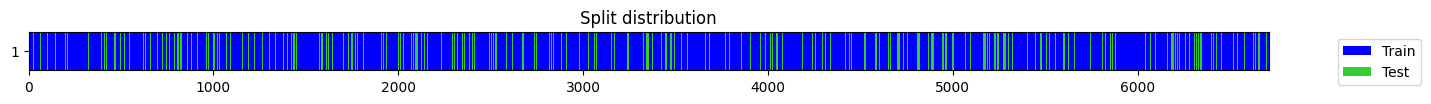

((#8228) [4222,3858,4149,5591,1373,5066,6338,1859,1042,3363...],
 (#1341) [6182,5646,5603,5918,6331,6411,55,2900,3919,2001...])

In [54]:
splits = get_splits(y_windowed, valid_size=0.2, random_state=23, shuffle=True, balance=True)
splits

In [55]:
tfms  = [None, [TSStandardize(by_var=True), Categorize()]]
batch_tfms = [TSStandardize(by_sample=True)]
dls = get_ts_dls(X_windowed, y_windowed, splits=splits, tfms=tfms, shuffle_train=True, batch_tfms=batch_tfms, bs=[64,256])

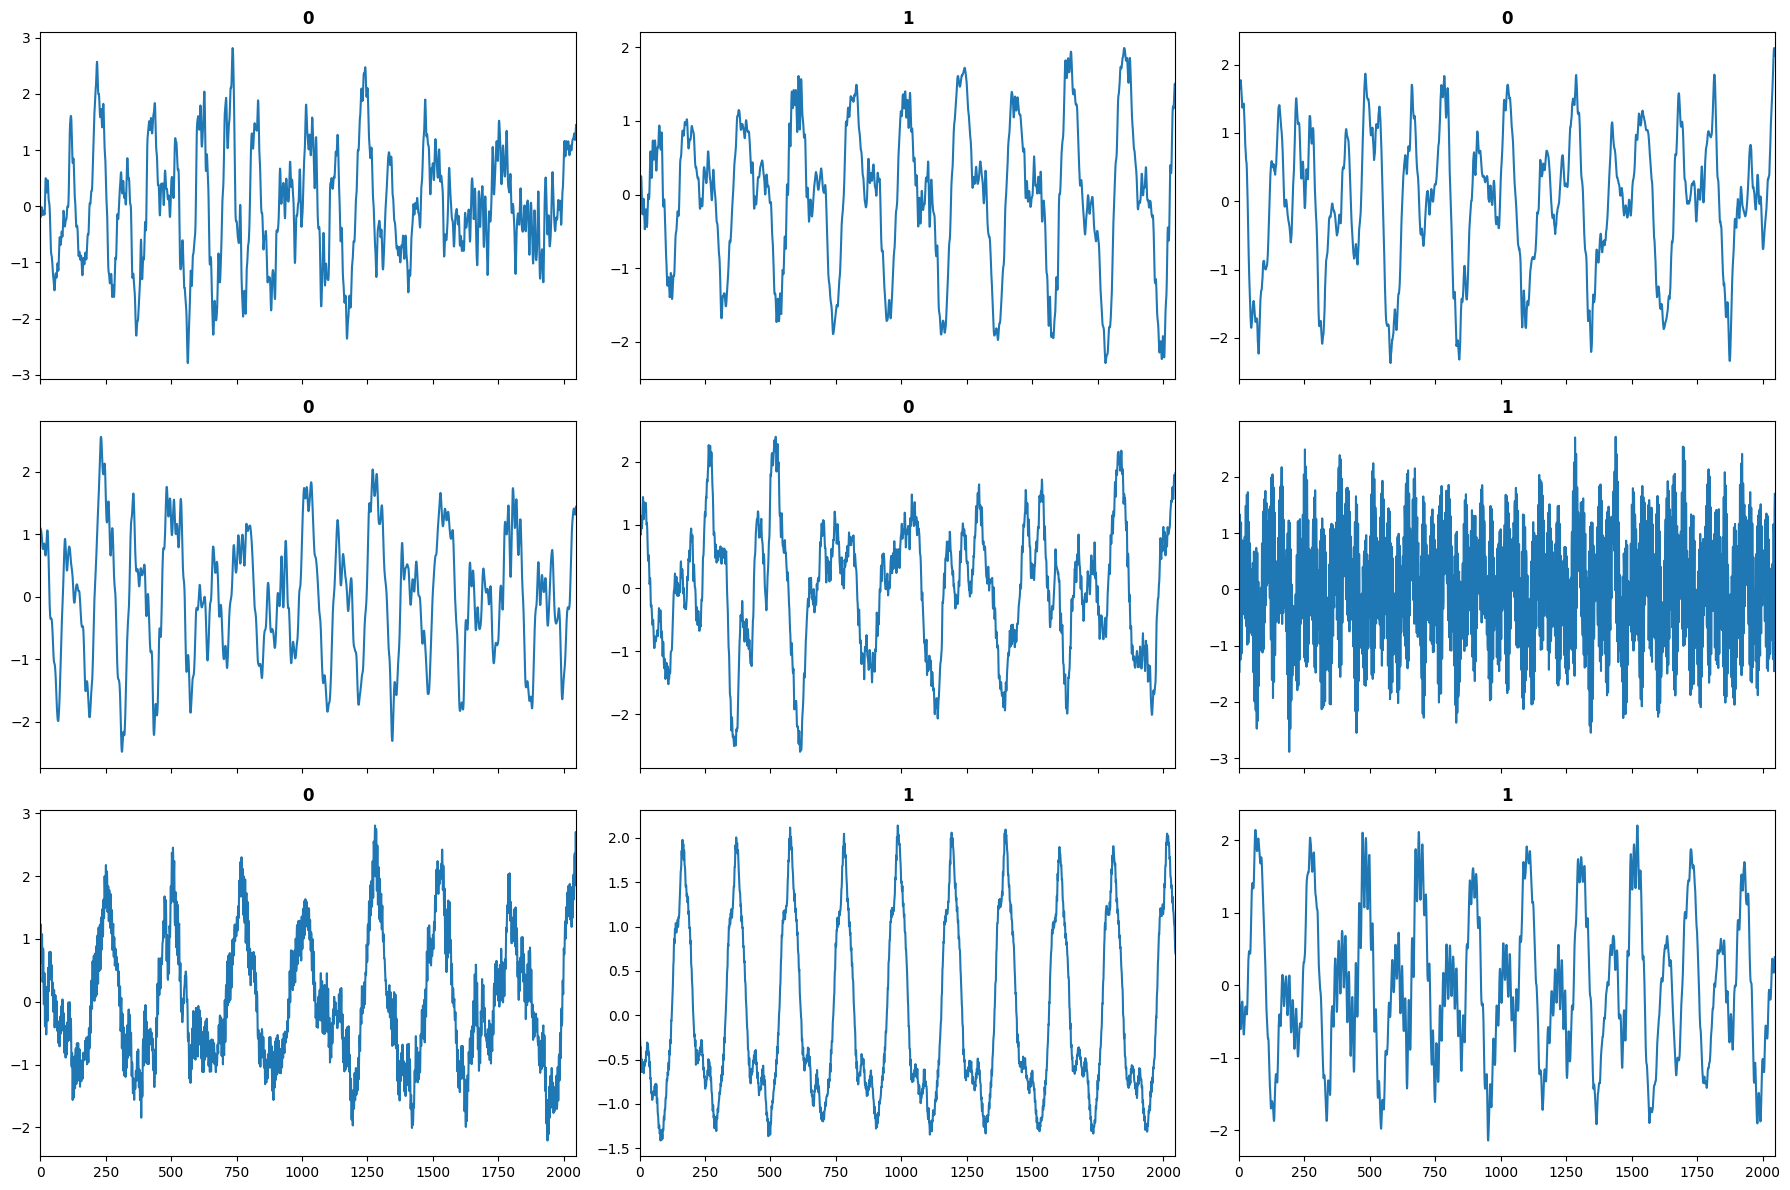

In [56]:
dls.show_batch(sharex=True)

In [ ]:
model = InceptionTime(dls.vars, dls.c)
# model = MLP(c_in=1,c_out=2,seq_len=4092  )
learn = Learner(dls, model, metrics=[accuracy, Precision(), Recall(), F1Score()])

In [ ]:
learn.fit_one_cycle(15, lr_max=learn.lr_find(), cbs=[PredictionDynamics()])

In [ ]:
learn.show_probas()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
!pip install optuna-integration
!pip install optuna

In [92]:
#CustomCNN According to the accuracy
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Define the model architecture
class CustomCNN(nn.Module):
    def __init__(self, num_filters=16, dropout_rate=0.2):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, num_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(num_filters, num_filters*2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(num_filters*2, num_filters*4, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(num_filters*4*4*4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# Define the function to train and evaluate the model
def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=10, device='cuda'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Training Loss: {epoch_loss:.4f}")
        validate_model(model, criterion, valid_loader, device=device)

def validate_model(model, criterion, valid_loader, device='cuda'):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(valid_loader.dataset)
    val_accuracy = correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Define the objective function for Optuna
def objective(trial):
    num_filters = trial.suggest_categorical('num_filters', [16, 32, 64])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)

    model = CustomCNN(num_filters=num_filters, dropout_rate=dropout_rate)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

    train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=10)

    # Evaluate the model on the validation set and return the validation accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

# Load CIFAR-10 dataset and split into train and validation sets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_data, valid_data = train_test_split(cifar10_train, test_size=0.2, random_state=42)

train_dataset = train_data
valid_dataset = valid_data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and validation accuracy
best_trial = study.best_trial
print(f"Best trial - Params: {best_trial.params}, Accuracy: {best_trial.value:.4f}")


100%|██████████| 170498071/170498071 [00:05<00:00, 28523975.59it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


[I 2024-04-07 18:45:18,239] A new study created in memory with name: no-name-2dbb103a-693e-4722-9ec9-03f4a7f0a362
Epoch 1/10: 100%|██████████| 625/625 [00:02<00:00, 280.30it/s]


Training Loss: 1.5605
Validation Loss: 1.2620, Validation Accuracy: 0.5414


Epoch 2/10: 100%|██████████| 625/625 [00:02<00:00, 302.83it/s]


Training Loss: 1.1913
Validation Loss: 1.0646, Validation Accuracy: 0.6243


Epoch 3/10: 100%|██████████| 625/625 [00:02<00:00, 297.62it/s]


Training Loss: 1.0242
Validation Loss: 0.9627, Validation Accuracy: 0.6638


Epoch 4/10: 100%|██████████| 625/625 [00:02<00:00, 301.87it/s]


Training Loss: 0.9064
Validation Loss: 0.9019, Validation Accuracy: 0.6814


Epoch 5/10: 100%|██████████| 625/625 [00:02<00:00, 294.37it/s]


Training Loss: 0.8232
Validation Loss: 0.8544, Validation Accuracy: 0.6970


Epoch 6/10: 100%|██████████| 625/625 [00:02<00:00, 301.81it/s]


Training Loss: 0.7528
Validation Loss: 0.8044, Validation Accuracy: 0.7169


Epoch 7/10: 100%|██████████| 625/625 [00:02<00:00, 300.81it/s]


Training Loss: 0.6869
Validation Loss: 0.7952, Validation Accuracy: 0.7220


Epoch 8/10: 100%|██████████| 625/625 [00:02<00:00, 283.23it/s]


Training Loss: 0.6304
Validation Loss: 0.7723, Validation Accuracy: 0.7343


Epoch 9/10: 100%|██████████| 625/625 [00:02<00:00, 300.78it/s]


Training Loss: 0.5832
Validation Loss: 0.7697, Validation Accuracy: 0.7381


Epoch 10/10: 100%|██████████| 625/625 [00:02<00:00, 290.40it/s]


Training Loss: 0.5380


[I 2024-04-07 18:45:41,809] Trial 0 finished with value: 0.7341 and parameters: {'num_filters': 16, 'dropout_rate': 0.4809152912947575}. Best is trial 0 with value: 0.7341.


Validation Loss: 0.7875, Validation Accuracy: 0.7341


Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 204.02it/s]


Training Loss: 1.3626
Validation Loss: 1.0573, Validation Accuracy: 0.6282


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 206.70it/s]


Training Loss: 0.8954
Validation Loss: 0.8606, Validation Accuracy: 0.6921


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 205.15it/s]


Training Loss: 0.6807
Validation Loss: 0.7223, Validation Accuracy: 0.7463


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 205.88it/s]


Training Loss: 0.5171
Validation Loss: 0.6958, Validation Accuracy: 0.7630


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 206.87it/s]


Training Loss: 0.3722
Validation Loss: 0.7838, Validation Accuracy: 0.7543


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 206.47it/s]


Training Loss: 0.2576
Validation Loss: 0.8058, Validation Accuracy: 0.7645


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 206.04it/s]


Training Loss: 0.1700
Validation Loss: 0.9378, Validation Accuracy: 0.7591


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 203.97it/s]


Training Loss: 0.1327
Validation Loss: 1.1485, Validation Accuracy: 0.7419


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 204.66it/s]


Training Loss: 0.1083
Validation Loss: 1.1807, Validation Accuracy: 0.7528


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 206.03it/s]


Training Loss: 0.0972
Validation Loss: 1.1627, Validation Accuracy: 0.7593


[I 2024-04-07 18:46:15,481] Trial 1 finished with value: 0.7593 and parameters: {'num_filters': 64, 'dropout_rate': 0.07429107523684769}. Best is trial 1 with value: 0.7593.
Epoch 1/10: 100%|██████████| 625/625 [00:02<00:00, 244.04it/s]


Training Loss: 1.4547
Validation Loss: 1.1540, Validation Accuracy: 0.5929


Epoch 2/10: 100%|██████████| 625/625 [00:02<00:00, 245.04it/s]


Training Loss: 1.0225
Validation Loss: 0.9040, Validation Accuracy: 0.6770


Epoch 3/10: 100%|██████████| 625/625 [00:02<00:00, 244.26it/s]


Training Loss: 0.8182
Validation Loss: 0.8140, Validation Accuracy: 0.7131


Epoch 4/10: 100%|██████████| 625/625 [00:02<00:00, 245.70it/s]


Training Loss: 0.6888
Validation Loss: 0.7553, Validation Accuracy: 0.7379


Epoch 5/10: 100%|██████████| 625/625 [00:02<00:00, 242.45it/s]


Training Loss: 0.5705
Validation Loss: 0.7546, Validation Accuracy: 0.7465


Epoch 6/10: 100%|██████████| 625/625 [00:02<00:00, 240.73it/s]


Training Loss: 0.4723
Validation Loss: 0.7255, Validation Accuracy: 0.7556


Epoch 7/10: 100%|██████████| 625/625 [00:02<00:00, 239.76it/s]


Training Loss: 0.3913
Validation Loss: 0.7431, Validation Accuracy: 0.7557


Epoch 8/10: 100%|██████████| 625/625 [00:02<00:00, 243.47it/s]


Training Loss: 0.3117
Validation Loss: 0.8072, Validation Accuracy: 0.7585


Epoch 9/10: 100%|██████████| 625/625 [00:02<00:00, 240.26it/s]


Training Loss: 0.2464
Validation Loss: 0.8853, Validation Accuracy: 0.7553


Epoch 10/10: 100%|██████████| 625/625 [00:02<00:00, 243.17it/s]


Training Loss: 0.1916
Validation Loss: 0.9889, Validation Accuracy: 0.7431


[I 2024-04-07 18:46:43,883] Trial 2 finished with value: 0.7431 and parameters: {'num_filters': 32, 'dropout_rate': 0.15051152546008056}. Best is trial 1 with value: 0.7593.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 206.82it/s]


Training Loss: 1.4534
Validation Loss: 1.1136, Validation Accuracy: 0.6042


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 205.63it/s]


Training Loss: 1.0075
Validation Loss: 0.8959, Validation Accuracy: 0.6871


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 205.71it/s]


Training Loss: 0.8139
Validation Loss: 0.7580, Validation Accuracy: 0.7312


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 205.70it/s]


Training Loss: 0.6731
Validation Loss: 0.7158, Validation Accuracy: 0.7533


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 205.00it/s]


Training Loss: 0.5634
Validation Loss: 0.7650, Validation Accuracy: 0.7459


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 205.10it/s]


Training Loss: 0.4738
Validation Loss: 0.7489, Validation Accuracy: 0.7515


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 206.52it/s]


Training Loss: 0.3902
Validation Loss: 0.7104, Validation Accuracy: 0.7667


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 203.27it/s]


Training Loss: 0.3242
Validation Loss: 0.7374, Validation Accuracy: 0.7720


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 205.58it/s]


Training Loss: 0.2741
Validation Loss: 0.8023, Validation Accuracy: 0.7651


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 205.40it/s]


Training Loss: 0.2255
Validation Loss: 0.8573, Validation Accuracy: 0.7707


[I 2024-04-07 18:47:17,577] Trial 3 finished with value: 0.7707 and parameters: {'num_filters': 64, 'dropout_rate': 0.43731393167533533}. Best is trial 3 with value: 0.7707.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 207.91it/s]


Training Loss: 1.3869
Validation Loss: 1.0579, Validation Accuracy: 0.6146


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 207.15it/s]


Training Loss: 0.9370
Validation Loss: 0.8864, Validation Accuracy: 0.6909


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 206.91it/s]


Training Loss: 0.7231
Validation Loss: 0.7969, Validation Accuracy: 0.7263


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 205.04it/s]


Training Loss: 0.5589
Validation Loss: 0.7287, Validation Accuracy: 0.7511


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 206.49it/s]


Training Loss: 0.4267
Validation Loss: 0.7538, Validation Accuracy: 0.7554


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 206.48it/s]


Training Loss: 0.2991
Validation Loss: 0.7929, Validation Accuracy: 0.7525


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 205.96it/s]


Training Loss: 0.1986
Validation Loss: 0.9457, Validation Accuracy: 0.7583


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 203.07it/s]


Training Loss: 0.1427
Validation Loss: 1.0810, Validation Accuracy: 0.7530


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 204.98it/s]


Training Loss: 0.1136
Validation Loss: 1.1338, Validation Accuracy: 0.7635


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 205.66it/s]


Training Loss: 0.0939
Validation Loss: 1.1518, Validation Accuracy: 0.7538


[I 2024-04-07 18:47:51,193] Trial 4 finished with value: 0.7538 and parameters: {'num_filters': 64, 'dropout_rate': 0.04000402667191816}. Best is trial 3 with value: 0.7707.
Epoch 1/10: 100%|██████████| 625/625 [00:02<00:00, 249.95it/s]


Training Loss: 1.4238
Validation Loss: 1.1194, Validation Accuracy: 0.5982


Epoch 2/10: 100%|██████████| 625/625 [00:02<00:00, 245.97it/s]


Training Loss: 1.0011
Validation Loss: 0.9266, Validation Accuracy: 0.6684


Epoch 3/10: 100%|██████████| 625/625 [00:02<00:00, 247.09it/s]


Training Loss: 0.7990
Validation Loss: 0.7994, Validation Accuracy: 0.7223


Epoch 4/10: 100%|██████████| 625/625 [00:02<00:00, 243.95it/s]


Training Loss: 0.6614
Validation Loss: 0.7731, Validation Accuracy: 0.7302


Epoch 5/10: 100%|██████████| 625/625 [00:02<00:00, 246.24it/s]


Training Loss: 0.5456
Validation Loss: 0.7285, Validation Accuracy: 0.7469


Epoch 6/10: 100%|██████████| 625/625 [00:02<00:00, 246.21it/s]


Training Loss: 0.4408
Validation Loss: 0.7920, Validation Accuracy: 0.7438


Epoch 7/10: 100%|██████████| 625/625 [00:02<00:00, 244.76it/s]


Training Loss: 0.3474
Validation Loss: 0.7892, Validation Accuracy: 0.7555


Epoch 8/10: 100%|██████████| 625/625 [00:02<00:00, 244.12it/s]


Training Loss: 0.2731
Validation Loss: 0.8796, Validation Accuracy: 0.7526


Epoch 9/10: 100%|██████████| 625/625 [00:02<00:00, 250.35it/s]


Training Loss: 0.2078
Validation Loss: 0.9255, Validation Accuracy: 0.7591


Epoch 10/10: 100%|██████████| 625/625 [00:02<00:00, 246.24it/s]


Training Loss: 0.1716
Validation Loss: 1.0154, Validation Accuracy: 0.7551


[I 2024-04-07 18:48:19,151] Trial 5 finished with value: 0.7551 and parameters: {'num_filters': 32, 'dropout_rate': 0.1508954866866294}. Best is trial 3 with value: 0.7707.
Epoch 1/10: 100%|██████████| 625/625 [00:02<00:00, 249.33it/s]


Training Loss: 1.4463
Validation Loss: 1.1753, Validation Accuracy: 0.5779


Epoch 2/10: 100%|██████████| 625/625 [00:02<00:00, 250.33it/s]


Training Loss: 1.0173
Validation Loss: 0.9452, Validation Accuracy: 0.6670


Epoch 3/10: 100%|██████████| 625/625 [00:02<00:00, 245.73it/s]


Training Loss: 0.8105
Validation Loss: 0.8284, Validation Accuracy: 0.7086


Epoch 4/10: 100%|██████████| 625/625 [00:02<00:00, 244.85it/s]


Training Loss: 0.6608
Validation Loss: 0.7409, Validation Accuracy: 0.7468


Epoch 5/10: 100%|██████████| 625/625 [00:02<00:00, 246.79it/s]


Training Loss: 0.5346
Validation Loss: 0.7767, Validation Accuracy: 0.7389


Epoch 6/10: 100%|██████████| 625/625 [00:02<00:00, 244.85it/s]


Training Loss: 0.4252
Validation Loss: 0.8012, Validation Accuracy: 0.7448


Epoch 7/10: 100%|██████████| 625/625 [00:02<00:00, 245.14it/s]


Training Loss: 0.3380
Validation Loss: 0.8108, Validation Accuracy: 0.7509


Epoch 8/10: 100%|██████████| 625/625 [00:02<00:00, 247.41it/s]


Training Loss: 0.2526
Validation Loss: 0.8761, Validation Accuracy: 0.7535


Epoch 9/10: 100%|██████████| 625/625 [00:02<00:00, 246.81it/s]


Training Loss: 0.1870
Validation Loss: 0.9891, Validation Accuracy: 0.7432


Epoch 10/10: 100%|██████████| 625/625 [00:02<00:00, 245.49it/s]


Training Loss: 0.1504
Validation Loss: 1.0753, Validation Accuracy: 0.7512


[I 2024-04-07 18:48:47,090] Trial 6 finished with value: 0.7512 and parameters: {'num_filters': 32, 'dropout_rate': 0.07534046802870992}. Best is trial 3 with value: 0.7707.
Epoch 1/10: 100%|██████████| 625/625 [00:02<00:00, 300.19it/s]


Training Loss: 1.5394
Validation Loss: 1.2665, Validation Accuracy: 0.5482


Epoch 2/10: 100%|██████████| 625/625 [00:02<00:00, 296.86it/s]


Training Loss: 1.1840
Validation Loss: 1.0699, Validation Accuracy: 0.6233


Epoch 3/10: 100%|██████████| 625/625 [00:02<00:00, 308.09it/s]


Training Loss: 1.0040
Validation Loss: 0.9536, Validation Accuracy: 0.6641


Epoch 4/10: 100%|██████████| 625/625 [00:02<00:00, 299.74it/s]


Training Loss: 0.8858
Validation Loss: 0.8946, Validation Accuracy: 0.6879


Epoch 5/10: 100%|██████████| 625/625 [00:02<00:00, 301.62it/s]


Training Loss: 0.7835
Validation Loss: 0.8326, Validation Accuracy: 0.7106


Epoch 6/10: 100%|██████████| 625/625 [00:02<00:00, 296.69it/s]


Training Loss: 0.7021
Validation Loss: 0.8384, Validation Accuracy: 0.7092


Epoch 7/10: 100%|██████████| 625/625 [00:02<00:00, 301.50it/s]


Training Loss: 0.6335
Validation Loss: 0.8253, Validation Accuracy: 0.7183


Epoch 8/10: 100%|██████████| 625/625 [00:02<00:00, 302.91it/s]


Training Loss: 0.5683
Validation Loss: 0.8003, Validation Accuracy: 0.7298


Epoch 9/10: 100%|██████████| 625/625 [00:02<00:00, 304.04it/s]


Training Loss: 0.5091
Validation Loss: 0.8026, Validation Accuracy: 0.7353


Epoch 10/10: 100%|██████████| 625/625 [00:02<00:00, 294.90it/s]


Training Loss: 0.4532


[I 2024-04-07 18:49:10,227] Trial 7 finished with value: 0.7403 and parameters: {'num_filters': 16, 'dropout_rate': 0.31143919405521303}. Best is trial 3 with value: 0.7707.


Validation Loss: 0.8199, Validation Accuracy: 0.7403


Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 207.19it/s]


Training Loss: 1.4269
Validation Loss: 1.0999, Validation Accuracy: 0.6068


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 202.57it/s]


Training Loss: 0.9908
Validation Loss: 0.8779, Validation Accuracy: 0.6893


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 203.86it/s]


Training Loss: 0.7799
Validation Loss: 0.7867, Validation Accuracy: 0.7263


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 206.31it/s]


Training Loss: 0.6433
Validation Loss: 0.7549, Validation Accuracy: 0.7419


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 206.66it/s]


Training Loss: 0.5160
Validation Loss: 0.7165, Validation Accuracy: 0.7596


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 204.33it/s]


Training Loss: 0.4111
Validation Loss: 0.6996, Validation Accuracy: 0.7733


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 205.82it/s]


Training Loss: 0.3266
Validation Loss: 0.7938, Validation Accuracy: 0.7634


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 204.67it/s]


Training Loss: 0.2557
Validation Loss: 0.7966, Validation Accuracy: 0.7700


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 203.77it/s]


Training Loss: 0.1978
Validation Loss: 0.9094, Validation Accuracy: 0.7658


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 205.33it/s]


Training Loss: 0.1597
Validation Loss: 0.9707, Validation Accuracy: 0.7655


[I 2024-04-07 18:49:43,963] Trial 8 finished with value: 0.7655 and parameters: {'num_filters': 64, 'dropout_rate': 0.22653103496935478}. Best is trial 3 with value: 0.7707.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 207.06it/s]


Training Loss: 1.3911
Validation Loss: 1.0803, Validation Accuracy: 0.6149


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 203.57it/s]


Training Loss: 0.9304
Validation Loss: 0.8053, Validation Accuracy: 0.7148


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 205.37it/s]


Training Loss: 0.7188
Validation Loss: 0.7648, Validation Accuracy: 0.7336


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 205.64it/s]


Training Loss: 0.5677
Validation Loss: 0.7009, Validation Accuracy: 0.7600


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 205.96it/s]


Training Loss: 0.4470
Validation Loss: 0.7150, Validation Accuracy: 0.7651


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 206.07it/s]


Training Loss: 0.3316
Validation Loss: 0.7414, Validation Accuracy: 0.7660


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 204.89it/s]


Training Loss: 0.2396
Validation Loss: 0.8725, Validation Accuracy: 0.7541


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 206.56it/s]


Training Loss: 0.1817
Validation Loss: 0.9644, Validation Accuracy: 0.7627


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 207.11it/s]


Training Loss: 0.1444
Validation Loss: 0.9720, Validation Accuracy: 0.7712


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 206.21it/s]


Training Loss: 0.1224
Validation Loss: 1.0709, Validation Accuracy: 0.7682


[I 2024-04-07 18:50:17,599] Trial 9 finished with value: 0.7682 and parameters: {'num_filters': 64, 'dropout_rate': 0.13321153923394813}. Best is trial 3 with value: 0.7707.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 203.97it/s]


Training Loss: 1.4435
Validation Loss: 1.1080, Validation Accuracy: 0.6108


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 206.81it/s]


Training Loss: 0.9972
Validation Loss: 0.8880, Validation Accuracy: 0.6921


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 206.73it/s]


Training Loss: 0.7972
Validation Loss: 0.7802, Validation Accuracy: 0.7263


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 205.82it/s]


Training Loss: 0.6697
Validation Loss: 0.7075, Validation Accuracy: 0.7524


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 206.35it/s]


Training Loss: 0.5561
Validation Loss: 0.7123, Validation Accuracy: 0.7585


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 206.31it/s]


Training Loss: 0.4649
Validation Loss: 0.7348, Validation Accuracy: 0.7636


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 205.61it/s]


Training Loss: 0.3828
Validation Loss: 0.7664, Validation Accuracy: 0.7693


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 206.54it/s]


Training Loss: 0.3145
Validation Loss: 0.7632, Validation Accuracy: 0.7717


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 207.08it/s]


Training Loss: 0.2613
Validation Loss: 0.7846, Validation Accuracy: 0.7671


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 203.45it/s]


Training Loss: 0.2177
Validation Loss: 0.8808, Validation Accuracy: 0.7696


[I 2024-04-07 18:50:51,214] Trial 10 finished with value: 0.7696 and parameters: {'num_filters': 64, 'dropout_rate': 0.4096206081410825}. Best is trial 3 with value: 0.7707.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 207.43it/s]


Training Loss: 1.4181
Validation Loss: 1.0723, Validation Accuracy: 0.6180


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 206.66it/s]


Training Loss: 0.9877
Validation Loss: 0.9013, Validation Accuracy: 0.6840


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 204.50it/s]


Training Loss: 0.7971
Validation Loss: 0.7866, Validation Accuracy: 0.7239


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 205.45it/s]


Training Loss: 0.6591
Validation Loss: 0.7213, Validation Accuracy: 0.7481


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 205.72it/s]


Training Loss: 0.5468
Validation Loss: 0.6975, Validation Accuracy: 0.7619


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 204.39it/s]


Training Loss: 0.4551
Validation Loss: 0.6865, Validation Accuracy: 0.7723


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 206.00it/s]


Training Loss: 0.3723
Validation Loss: 0.7497, Validation Accuracy: 0.7629


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 206.66it/s]


Training Loss: 0.3018
Validation Loss: 0.7974, Validation Accuracy: 0.7721


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 205.41it/s]


Training Loss: 0.2559
Validation Loss: 0.8247, Validation Accuracy: 0.7706


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 202.35it/s]


Training Loss: 0.2129
Validation Loss: 0.8450, Validation Accuracy: 0.7756


[I 2024-04-07 18:51:24,889] Trial 11 finished with value: 0.7756 and parameters: {'num_filters': 64, 'dropout_rate': 0.45040545961964024}. Best is trial 11 with value: 0.7756.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 207.78it/s]


Training Loss: 1.4468
Validation Loss: 1.1421, Validation Accuracy: 0.5952


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 205.60it/s]


Training Loss: 0.9990
Validation Loss: 0.9040, Validation Accuracy: 0.6763


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 204.80it/s]


Training Loss: 0.7990
Validation Loss: 0.8289, Validation Accuracy: 0.7101


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 205.04it/s]


Training Loss: 0.6685
Validation Loss: 0.7361, Validation Accuracy: 0.7471


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 204.76it/s]


Training Loss: 0.5588
Validation Loss: 0.6929, Validation Accuracy: 0.7672


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 205.56it/s]


Training Loss: 0.4675
Validation Loss: 0.7242, Validation Accuracy: 0.7595


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 206.23it/s]


Training Loss: 0.3787
Validation Loss: 0.7565, Validation Accuracy: 0.7626


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 205.34it/s]


Training Loss: 0.3106
Validation Loss: 0.7547, Validation Accuracy: 0.7696


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 201.65it/s]


Training Loss: 0.2626
Validation Loss: 0.8255, Validation Accuracy: 0.7700


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 205.64it/s]


Training Loss: 0.2108
Validation Loss: 0.9002, Validation Accuracy: 0.7692


[I 2024-04-07 18:51:58,593] Trial 12 finished with value: 0.7692 and parameters: {'num_filters': 64, 'dropout_rate': 0.38591077008307273}. Best is trial 11 with value: 0.7756.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 206.12it/s]


Training Loss: 1.4709
Validation Loss: 1.1678, Validation Accuracy: 0.5841


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 204.28it/s]


Training Loss: 1.0420
Validation Loss: 0.9657, Validation Accuracy: 0.6626


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 205.66it/s]


Training Loss: 0.8451
Validation Loss: 0.8113, Validation Accuracy: 0.7167


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 203.79it/s]


Training Loss: 0.7112
Validation Loss: 0.7135, Validation Accuracy: 0.7563


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 205.25it/s]


Training Loss: 0.6078
Validation Loss: 0.7112, Validation Accuracy: 0.7602


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 206.20it/s]


Training Loss: 0.5162
Validation Loss: 0.6976, Validation Accuracy: 0.7742


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 205.23it/s]


Training Loss: 0.4352
Validation Loss: 0.7262, Validation Accuracy: 0.7722


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 202.81it/s]


Training Loss: 0.3729
Validation Loss: 0.7191, Validation Accuracy: 0.7735


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 205.06it/s]


Training Loss: 0.3166
Validation Loss: 0.7760, Validation Accuracy: 0.7765


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 205.80it/s]


Training Loss: 0.2723
Validation Loss: 0.8107, Validation Accuracy: 0.7773


[I 2024-04-07 18:52:32,331] Trial 13 finished with value: 0.7773 and parameters: {'num_filters': 64, 'dropout_rate': 0.4828080479405911}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 208.12it/s]


Training Loss: 1.4249
Validation Loss: 1.0893, Validation Accuracy: 0.6102


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 206.15it/s]


Training Loss: 0.9728
Validation Loss: 0.8287, Validation Accuracy: 0.7095


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 206.19it/s]


Training Loss: 0.7627
Validation Loss: 0.7666, Validation Accuracy: 0.7284


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 205.38it/s]


Training Loss: 0.6170
Validation Loss: 0.7177, Validation Accuracy: 0.7509


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 205.30it/s]


Training Loss: 0.5034
Validation Loss: 0.6917, Validation Accuracy: 0.7651


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 204.08it/s]


Training Loss: 0.3979
Validation Loss: 0.7004, Validation Accuracy: 0.7756


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 204.83it/s]


Training Loss: 0.3110
Validation Loss: 0.7583, Validation Accuracy: 0.7668


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 202.08it/s]


Training Loss: 0.2425
Validation Loss: 0.7970, Validation Accuracy: 0.7632


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 204.83it/s]


Training Loss: 0.2010
Validation Loss: 0.8525, Validation Accuracy: 0.7730


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 204.15it/s]


Training Loss: 0.1604
Validation Loss: 0.9778, Validation Accuracy: 0.7699


[I 2024-04-07 18:53:06,050] Trial 14 finished with value: 0.7699 and parameters: {'num_filters': 64, 'dropout_rate': 0.33480221518737385}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:02<00:00, 304.58it/s]


Training Loss: 1.5808
Validation Loss: 1.3143, Validation Accuracy: 0.5184


Epoch 2/10: 100%|██████████| 625/625 [00:02<00:00, 296.28it/s]


Training Loss: 1.2262
Validation Loss: 1.0849, Validation Accuracy: 0.6146


Epoch 3/10: 100%|██████████| 625/625 [00:02<00:00, 297.72it/s]


Training Loss: 1.0519
Validation Loss: 0.9816, Validation Accuracy: 0.6548


Epoch 4/10: 100%|██████████| 625/625 [00:02<00:00, 298.78it/s]


Training Loss: 0.9380
Validation Loss: 0.8641, Validation Accuracy: 0.6971


Epoch 5/10: 100%|██████████| 625/625 [00:02<00:00, 300.83it/s]


Training Loss: 0.8448
Validation Loss: 0.8368, Validation Accuracy: 0.6992


Epoch 6/10: 100%|██████████| 625/625 [00:02<00:00, 296.44it/s]


Training Loss: 0.7728
Validation Loss: 0.8013, Validation Accuracy: 0.7164


Epoch 7/10: 100%|██████████| 625/625 [00:02<00:00, 295.33it/s]


Training Loss: 0.7135
Validation Loss: 0.8094, Validation Accuracy: 0.7171


Epoch 8/10: 100%|██████████| 625/625 [00:02<00:00, 295.15it/s]


Training Loss: 0.6563
Validation Loss: 0.7860, Validation Accuracy: 0.7234


Epoch 9/10: 100%|██████████| 625/625 [00:02<00:00, 293.16it/s]


Training Loss: 0.6120
Validation Loss: 0.7507, Validation Accuracy: 0.7358


Epoch 10/10: 100%|██████████| 625/625 [00:02<00:00, 278.22it/s]


Training Loss: 0.5686


[I 2024-04-07 18:53:29,537] Trial 15 finished with value: 0.736 and parameters: {'num_filters': 16, 'dropout_rate': 0.49870173338235696}. Best is trial 13 with value: 0.7773.


Validation Loss: 0.7690, Validation Accuracy: 0.7360


Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 204.82it/s]


Training Loss: 1.4208
Validation Loss: 1.0869, Validation Accuracy: 0.6195


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 204.73it/s]


Training Loss: 0.9702
Validation Loss: 0.8634, Validation Accuracy: 0.6954


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 202.35it/s]


Training Loss: 0.7664
Validation Loss: 0.7618, Validation Accuracy: 0.7315


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 203.45it/s]


Training Loss: 0.6244
Validation Loss: 0.7182, Validation Accuracy: 0.7503


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 202.51it/s]


Training Loss: 0.5107
Validation Loss: 0.6974, Validation Accuracy: 0.7624


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 202.53it/s]


Training Loss: 0.4082
Validation Loss: 0.7297, Validation Accuracy: 0.7653


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 202.87it/s]


Training Loss: 0.3246
Validation Loss: 0.7455, Validation Accuracy: 0.7694


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 202.77it/s]


Training Loss: 0.2629
Validation Loss: 0.8133, Validation Accuracy: 0.7693


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 198.32it/s]


Training Loss: 0.2166
Validation Loss: 0.8680, Validation Accuracy: 0.7603


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 201.29it/s]


Training Loss: 0.1783
Validation Loss: 0.9427, Validation Accuracy: 0.7637


[I 2024-04-07 18:54:03,690] Trial 16 finished with value: 0.7637 and parameters: {'num_filters': 64, 'dropout_rate': 0.32385351792895734}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 203.75it/s]


Training Loss: 1.3707
Validation Loss: 1.0476, Validation Accuracy: 0.6223


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 203.97it/s]


Training Loss: 0.9259
Validation Loss: 0.8173, Validation Accuracy: 0.7100


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 206.80it/s]


Training Loss: 0.7132
Validation Loss: 0.7553, Validation Accuracy: 0.7367


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 204.88it/s]


Training Loss: 0.5637
Validation Loss: 0.7168, Validation Accuracy: 0.7497


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 206.10it/s]


Training Loss: 0.4410
Validation Loss: 0.7121, Validation Accuracy: 0.7734


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 206.52it/s]


Training Loss: 0.3355
Validation Loss: 0.7448, Validation Accuracy: 0.7726


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 207.08it/s]


Training Loss: 0.2516
Validation Loss: 0.7937, Validation Accuracy: 0.7663


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 204.20it/s]


Training Loss: 0.1879
Validation Loss: 0.8743, Validation Accuracy: 0.7712


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 204.47it/s]


Training Loss: 0.1561
Validation Loss: 0.9574, Validation Accuracy: 0.7578


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 206.67it/s]


Training Loss: 0.1361
Validation Loss: 0.9801, Validation Accuracy: 0.7708


[I 2024-04-07 18:54:37,368] Trial 17 finished with value: 0.7708 and parameters: {'num_filters': 64, 'dropout_rate': 0.2523784211942453}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:02<00:00, 245.56it/s]


Training Loss: 1.4722
Validation Loss: 1.1382, Validation Accuracy: 0.5965


Epoch 2/10: 100%|██████████| 625/625 [00:02<00:00, 244.34it/s]


Training Loss: 1.0581
Validation Loss: 0.8981, Validation Accuracy: 0.6839


Epoch 3/10: 100%|██████████| 625/625 [00:02<00:00, 243.93it/s]


Training Loss: 0.8752
Validation Loss: 0.8441, Validation Accuracy: 0.7040


Epoch 4/10: 100%|██████████| 625/625 [00:02<00:00, 242.82it/s]


Training Loss: 0.7495
Validation Loss: 0.7415, Validation Accuracy: 0.7396


Epoch 5/10: 100%|██████████| 625/625 [00:02<00:00, 243.99it/s]


Training Loss: 0.6481
Validation Loss: 0.7034, Validation Accuracy: 0.7555


Epoch 6/10: 100%|██████████| 625/625 [00:02<00:00, 245.84it/s]


Training Loss: 0.5598
Validation Loss: 0.7044, Validation Accuracy: 0.7610


Epoch 7/10: 100%|██████████| 625/625 [00:02<00:00, 248.14it/s]


Training Loss: 0.4856
Validation Loss: 0.7192, Validation Accuracy: 0.7592


Epoch 8/10: 100%|██████████| 625/625 [00:02<00:00, 244.56it/s]


Training Loss: 0.4160
Validation Loss: 0.7423, Validation Accuracy: 0.7558


Epoch 9/10: 100%|██████████| 625/625 [00:02<00:00, 243.34it/s]


Training Loss: 0.3546
Validation Loss: 0.7900, Validation Accuracy: 0.7617


Epoch 10/10: 100%|██████████| 625/625 [00:02<00:00, 248.44it/s]


Training Loss: 0.3083
Validation Loss: 0.8016, Validation Accuracy: 0.7693


[I 2024-04-07 18:55:05,488] Trial 18 finished with value: 0.7693 and parameters: {'num_filters': 32, 'dropout_rate': 0.4598791944340831}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:02<00:00, 305.55it/s]


Training Loss: 1.5565
Validation Loss: 1.2686, Validation Accuracy: 0.5393


Epoch 2/10: 100%|██████████| 625/625 [00:02<00:00, 296.25it/s]


Training Loss: 1.1889
Validation Loss: 1.0948, Validation Accuracy: 0.6130


Epoch 3/10: 100%|██████████| 625/625 [00:02<00:00, 301.66it/s]


Training Loss: 1.0010
Validation Loss: 0.9324, Validation Accuracy: 0.6685


Epoch 4/10: 100%|██████████| 625/625 [00:02<00:00, 299.93it/s]


Training Loss: 0.8715
Validation Loss: 0.8554, Validation Accuracy: 0.6971


Epoch 5/10: 100%|██████████| 625/625 [00:02<00:00, 300.11it/s]


Training Loss: 0.7728
Validation Loss: 0.8471, Validation Accuracy: 0.7057


Epoch 6/10: 100%|██████████| 625/625 [00:02<00:00, 301.46it/s]


Training Loss: 0.7017
Validation Loss: 0.7702, Validation Accuracy: 0.7355


Epoch 7/10: 100%|██████████| 625/625 [00:02<00:00, 299.64it/s]


Training Loss: 0.6351
Validation Loss: 0.7827, Validation Accuracy: 0.7328


Epoch 8/10: 100%|██████████| 625/625 [00:02<00:00, 302.83it/s]


Training Loss: 0.5718
Validation Loss: 0.7747, Validation Accuracy: 0.7367


Epoch 9/10: 100%|██████████| 625/625 [00:02<00:00, 300.65it/s]


Training Loss: 0.5217
Validation Loss: 0.7850, Validation Accuracy: 0.7392


Epoch 10/10: 100%|██████████| 625/625 [00:02<00:00, 303.77it/s]


Training Loss: 0.4672


[I 2024-04-07 18:55:28,566] Trial 19 finished with value: 0.7483 and parameters: {'num_filters': 16, 'dropout_rate': 0.3773693452933947}. Best is trial 13 with value: 0.7773.


Validation Loss: 0.7833, Validation Accuracy: 0.7483


Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 204.12it/s]


Training Loss: 1.4273
Validation Loss: 1.0788, Validation Accuracy: 0.6184


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 203.44it/s]


Training Loss: 0.9691
Validation Loss: 0.8628, Validation Accuracy: 0.6995


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 205.94it/s]


Training Loss: 0.7656
Validation Loss: 0.9063, Validation Accuracy: 0.6877


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 204.66it/s]


Training Loss: 0.6231
Validation Loss: 0.7278, Validation Accuracy: 0.7470


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 205.60it/s]


Training Loss: 0.5127
Validation Loss: 0.7370, Validation Accuracy: 0.7436


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 206.00it/s]


Training Loss: 0.4156
Validation Loss: 0.7088, Validation Accuracy: 0.7715


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 205.22it/s]


Training Loss: 0.3249
Validation Loss: 0.7496, Validation Accuracy: 0.7646


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 205.88it/s]


Training Loss: 0.2561
Validation Loss: 0.8468, Validation Accuracy: 0.7689


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 205.46it/s]


Training Loss: 0.1999
Validation Loss: 0.9135, Validation Accuracy: 0.7676


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 203.73it/s]


Training Loss: 0.1680
Validation Loss: 0.9640, Validation Accuracy: 0.7721


[I 2024-04-07 18:56:02,316] Trial 20 finished with value: 0.7721 and parameters: {'num_filters': 64, 'dropout_rate': 0.25081608485124995}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 202.93it/s]


Training Loss: 1.4068
Validation Loss: 1.0353, Validation Accuracy: 0.6301


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 206.58it/s]


Training Loss: 0.9425
Validation Loss: 0.8611, Validation Accuracy: 0.6922


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 204.94it/s]


Training Loss: 0.7470
Validation Loss: 0.7527, Validation Accuracy: 0.7336


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 205.29it/s]


Training Loss: 0.5980
Validation Loss: 0.7148, Validation Accuracy: 0.7531


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 204.25it/s]


Training Loss: 0.4808
Validation Loss: 0.7010, Validation Accuracy: 0.7690


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 206.21it/s]


Training Loss: 0.3732
Validation Loss: 0.7300, Validation Accuracy: 0.7735


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 205.05it/s]


Training Loss: 0.2831
Validation Loss: 0.8255, Validation Accuracy: 0.7635


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 205.50it/s]


Training Loss: 0.2142
Validation Loss: 0.8916, Validation Accuracy: 0.7679


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 204.08it/s]


Training Loss: 0.1755
Validation Loss: 0.9120, Validation Accuracy: 0.7676


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 206.46it/s]


Training Loss: 0.1409
Validation Loss: 1.0128, Validation Accuracy: 0.7696


[I 2024-04-07 18:56:36,042] Trial 21 finished with value: 0.7696 and parameters: {'num_filters': 64, 'dropout_rate': 0.24603593304599458}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 204.27it/s]


Training Loss: 1.4224
Validation Loss: 1.0439, Validation Accuracy: 0.6288


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 205.01it/s]


Training Loss: 0.9961
Validation Loss: 0.8973, Validation Accuracy: 0.6831


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 206.57it/s]


Training Loss: 0.8023
Validation Loss: 0.7992, Validation Accuracy: 0.7184


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 205.59it/s]


Training Loss: 0.6625
Validation Loss: 0.7118, Validation Accuracy: 0.7585


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 204.42it/s]


Training Loss: 0.5485
Validation Loss: 0.7179, Validation Accuracy: 0.7590


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 206.46it/s]


Training Loss: 0.4464
Validation Loss: 0.7145, Validation Accuracy: 0.7642


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 205.04it/s]


Training Loss: 0.3696
Validation Loss: 0.7580, Validation Accuracy: 0.7666


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 205.12it/s]


Training Loss: 0.3058
Validation Loss: 0.8499, Validation Accuracy: 0.7624


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 205.14it/s]


Training Loss: 0.2501
Validation Loss: 0.8358, Validation Accuracy: 0.7697


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 204.00it/s]


Training Loss: 0.2077
Validation Loss: 0.9023, Validation Accuracy: 0.7639


[I 2024-04-07 18:57:09,775] Trial 22 finished with value: 0.7639 and parameters: {'num_filters': 64, 'dropout_rate': 0.4264806442406616}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 207.37it/s]


Training Loss: 1.4336
Validation Loss: 1.0880, Validation Accuracy: 0.6095


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 206.17it/s]


Training Loss: 1.0023
Validation Loss: 0.9059, Validation Accuracy: 0.6798


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 204.89it/s]


Training Loss: 0.8105
Validation Loss: 0.8069, Validation Accuracy: 0.7188


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 205.02it/s]


Training Loss: 0.6756
Validation Loss: 0.7525, Validation Accuracy: 0.7399


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 206.96it/s]


Training Loss: 0.5695
Validation Loss: 0.7151, Validation Accuracy: 0.7573


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 205.82it/s]


Training Loss: 0.4692
Validation Loss: 0.7325, Validation Accuracy: 0.7614


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 205.56it/s]


Training Loss: 0.3934
Validation Loss: 0.7147, Validation Accuracy: 0.7703


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 204.88it/s]


Training Loss: 0.3180
Validation Loss: 0.7733, Validation Accuracy: 0.7675


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 204.61it/s]


Training Loss: 0.2606
Validation Loss: 0.8181, Validation Accuracy: 0.7720


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 205.16it/s]


Training Loss: 0.2294
Validation Loss: 0.8677, Validation Accuracy: 0.7703


[I 2024-04-07 18:57:43,464] Trial 23 finished with value: 0.7703 and parameters: {'num_filters': 64, 'dropout_rate': 0.3601753288153672}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 206.77it/s]


Training Loss: 1.3899
Validation Loss: 1.0666, Validation Accuracy: 0.6220


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 203.29it/s]


Training Loss: 0.9492
Validation Loss: 0.8414, Validation Accuracy: 0.7081


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 205.05it/s]


Training Loss: 0.7406
Validation Loss: 0.7379, Validation Accuracy: 0.7451


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 206.49it/s]


Training Loss: 0.6000
Validation Loss: 0.7066, Validation Accuracy: 0.7588


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 204.94it/s]


Training Loss: 0.4697
Validation Loss: 0.7273, Validation Accuracy: 0.7608


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 204.34it/s]


Training Loss: 0.3582
Validation Loss: 0.7240, Validation Accuracy: 0.7672


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 204.68it/s]


Training Loss: 0.2706
Validation Loss: 0.8144, Validation Accuracy: 0.7593


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 205.06it/s]


Training Loss: 0.2157
Validation Loss: 0.8184, Validation Accuracy: 0.7727


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 203.33it/s]


Training Loss: 0.1729
Validation Loss: 0.9852, Validation Accuracy: 0.7652


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 206.22it/s]


Training Loss: 0.1446
Validation Loss: 1.1062, Validation Accuracy: 0.7526


[I 2024-04-07 18:58:17,206] Trial 24 finished with value: 0.7526 and parameters: {'num_filters': 64, 'dropout_rate': 0.2879337310985279}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 206.98it/s]


Training Loss: 1.4326
Validation Loss: 1.1062, Validation Accuracy: 0.6081


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 206.10it/s]


Training Loss: 0.9853
Validation Loss: 0.8859, Validation Accuracy: 0.6884


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 205.27it/s]


Training Loss: 0.7789
Validation Loss: 0.7855, Validation Accuracy: 0.7297


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 204.99it/s]


Training Loss: 0.6341
Validation Loss: 0.7656, Validation Accuracy: 0.7371


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 204.84it/s]


Training Loss: 0.5146
Validation Loss: 0.7369, Validation Accuracy: 0.7520


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 203.90it/s]


Training Loss: 0.4040
Validation Loss: 0.7685, Validation Accuracy: 0.7483


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 204.69it/s]


Training Loss: 0.3144
Validation Loss: 0.7983, Validation Accuracy: 0.7651


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 203.78it/s]


Training Loss: 0.2474
Validation Loss: 0.8952, Validation Accuracy: 0.7599


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 206.40it/s]


Training Loss: 0.1957
Validation Loss: 0.9749, Validation Accuracy: 0.7564


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 204.80it/s]


Training Loss: 0.1528
Validation Loss: 1.0369, Validation Accuracy: 0.7557


[I 2024-04-07 18:58:50,927] Trial 25 finished with value: 0.7557 and parameters: {'num_filters': 64, 'dropout_rate': 0.20275738528546625}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 206.28it/s]


Training Loss: 1.4893
Validation Loss: 1.2098, Validation Accuracy: 0.5546


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 205.25it/s]


Training Loss: 1.0462
Validation Loss: 0.9058, Validation Accuracy: 0.6793


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 204.65it/s]


Training Loss: 0.8311
Validation Loss: 0.7826, Validation Accuracy: 0.7289


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 205.30it/s]


Training Loss: 0.6905
Validation Loss: 0.7307, Validation Accuracy: 0.7459


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 206.11it/s]


Training Loss: 0.5861
Validation Loss: 0.6871, Validation Accuracy: 0.7634


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 205.04it/s]


Training Loss: 0.4964
Validation Loss: 0.7204, Validation Accuracy: 0.7569


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 203.32it/s]


Training Loss: 0.4213
Validation Loss: 0.7360, Validation Accuracy: 0.7638


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 204.86it/s]


Training Loss: 0.3552
Validation Loss: 0.7427, Validation Accuracy: 0.7716


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 205.76it/s]


Training Loss: 0.2936
Validation Loss: 0.7815, Validation Accuracy: 0.7722


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 205.54it/s]


Training Loss: 0.2521
Validation Loss: 0.8122, Validation Accuracy: 0.7654


[I 2024-04-07 18:59:24,671] Trial 26 finished with value: 0.7654 and parameters: {'num_filters': 64, 'dropout_rate': 0.45664274935402477}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 207.57it/s]


Training Loss: 1.3705
Validation Loss: 1.0440, Validation Accuracy: 0.6249


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 205.65it/s]


Training Loss: 0.9076
Validation Loss: 0.8632, Validation Accuracy: 0.6941


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 206.53it/s]


Training Loss: 0.6829
Validation Loss: 0.7565, Validation Accuracy: 0.7355


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 203.85it/s]


Training Loss: 0.5217
Validation Loss: 0.7369, Validation Accuracy: 0.7499


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 203.49it/s]


Training Loss: 0.3811
Validation Loss: 0.7390, Validation Accuracy: 0.7628


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 205.71it/s]


Training Loss: 0.2561
Validation Loss: 0.8192, Validation Accuracy: 0.7650


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 203.40it/s]


Training Loss: 0.1672
Validation Loss: 0.9950, Validation Accuracy: 0.7514


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 204.77it/s]


Training Loss: 0.1162
Validation Loss: 1.0239, Validation Accuracy: 0.7620


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 206.65it/s]


Training Loss: 0.1015
Validation Loss: 1.1518, Validation Accuracy: 0.7663


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 205.30it/s]


Training Loss: 0.0850
Validation Loss: 1.3149, Validation Accuracy: 0.7553


[I 2024-04-07 18:59:58,391] Trial 27 finished with value: 0.7553 and parameters: {'num_filters': 64, 'dropout_rate': 0.005622588988015209}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:02<00:00, 243.17it/s]


Training Loss: 1.4842
Validation Loss: 1.2127, Validation Accuracy: 0.5733


Epoch 2/10: 100%|██████████| 625/625 [00:02<00:00, 246.04it/s]


Training Loss: 1.0584
Validation Loss: 0.9542, Validation Accuracy: 0.6570


Epoch 3/10: 100%|██████████| 625/625 [00:02<00:00, 243.44it/s]


Training Loss: 0.8659
Validation Loss: 0.7998, Validation Accuracy: 0.7190


Epoch 4/10: 100%|██████████| 625/625 [00:02<00:00, 245.08it/s]


Training Loss: 0.7305
Validation Loss: 0.7802, Validation Accuracy: 0.7268


Epoch 5/10: 100%|██████████| 625/625 [00:02<00:00, 246.26it/s]


Training Loss: 0.6363
Validation Loss: 0.7533, Validation Accuracy: 0.7347


Epoch 6/10: 100%|██████████| 625/625 [00:02<00:00, 244.79it/s]


Training Loss: 0.5472
Validation Loss: 0.7250, Validation Accuracy: 0.7525


Epoch 7/10: 100%|██████████| 625/625 [00:02<00:00, 241.60it/s]


Training Loss: 0.4722
Validation Loss: 0.7662, Validation Accuracy: 0.7498


Epoch 8/10: 100%|██████████| 625/625 [00:02<00:00, 243.27it/s]


Training Loss: 0.3979
Validation Loss: 0.7565, Validation Accuracy: 0.7570


Epoch 9/10: 100%|██████████| 625/625 [00:02<00:00, 247.66it/s]


Training Loss: 0.3403
Validation Loss: 0.7918, Validation Accuracy: 0.7595


Epoch 10/10: 100%|██████████| 625/625 [00:02<00:00, 244.51it/s]


Training Loss: 0.2955
Validation Loss: 0.8173, Validation Accuracy: 0.7565


[I 2024-04-07 19:00:26,545] Trial 28 finished with value: 0.7565 and parameters: {'num_filters': 32, 'dropout_rate': 0.41162391196477927}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:02<00:00, 306.06it/s]


Training Loss: 1.5768
Validation Loss: 1.2732, Validation Accuracy: 0.5418


Epoch 2/10: 100%|██████████| 625/625 [00:02<00:00, 295.62it/s]


Training Loss: 1.2190
Validation Loss: 1.0812, Validation Accuracy: 0.6134


Epoch 3/10: 100%|██████████| 625/625 [00:02<00:00, 298.85it/s]


Training Loss: 1.0747
Validation Loss: 1.0017, Validation Accuracy: 0.6465


Epoch 4/10: 100%|██████████| 625/625 [00:02<00:00, 299.56it/s]


Training Loss: 0.9650
Validation Loss: 0.9451, Validation Accuracy: 0.6666


Epoch 5/10: 100%|██████████| 625/625 [00:02<00:00, 294.33it/s]


Training Loss: 0.8717
Validation Loss: 0.8565, Validation Accuracy: 0.6992


Epoch 6/10: 100%|██████████| 625/625 [00:02<00:00, 294.29it/s]


Training Loss: 0.7963
Validation Loss: 0.8334, Validation Accuracy: 0.7086


Epoch 7/10: 100%|██████████| 625/625 [00:02<00:00, 300.02it/s]


Training Loss: 0.7386
Validation Loss: 0.8005, Validation Accuracy: 0.7125


Epoch 8/10: 100%|██████████| 625/625 [00:02<00:00, 296.11it/s]


Training Loss: 0.6847
Validation Loss: 0.7785, Validation Accuracy: 0.7341


Epoch 9/10: 100%|██████████| 625/625 [00:02<00:00, 297.90it/s]


Training Loss: 0.6405
Validation Loss: 0.8135, Validation Accuracy: 0.7222


Epoch 10/10: 100%|██████████| 625/625 [00:02<00:00, 277.89it/s]


Training Loss: 0.5977


[I 2024-04-07 19:00:50,010] Trial 29 finished with value: 0.7297 and parameters: {'num_filters': 16, 'dropout_rate': 0.4984902813440723}. Best is trial 13 with value: 0.7773.


Validation Loss: 0.7957, Validation Accuracy: 0.7297


Epoch 1/10: 100%|██████████| 625/625 [00:02<00:00, 303.49it/s]


Training Loss: 1.5359
Validation Loss: 1.2521, Validation Accuracy: 0.5482


Epoch 2/10: 100%|██████████| 625/625 [00:02<00:00, 297.43it/s]


Training Loss: 1.1635
Validation Loss: 1.0516, Validation Accuracy: 0.6269


Epoch 3/10: 100%|██████████| 625/625 [00:02<00:00, 297.42it/s]


Training Loss: 0.9854
Validation Loss: 0.9870, Validation Accuracy: 0.6569


Epoch 4/10: 100%|██████████| 625/625 [00:02<00:00, 298.04it/s]


Training Loss: 0.8595
Validation Loss: 0.9068, Validation Accuracy: 0.6836


Epoch 5/10: 100%|██████████| 625/625 [00:02<00:00, 295.83it/s]


Training Loss: 0.7644
Validation Loss: 0.8359, Validation Accuracy: 0.7101


Epoch 6/10: 100%|██████████| 625/625 [00:02<00:00, 289.34it/s]


Training Loss: 0.6819
Validation Loss: 0.8257, Validation Accuracy: 0.7154


Epoch 7/10: 100%|██████████| 625/625 [00:02<00:00, 300.85it/s]


Training Loss: 0.6002
Validation Loss: 0.7997, Validation Accuracy: 0.7293


Epoch 8/10: 100%|██████████| 625/625 [00:02<00:00, 296.08it/s]


Training Loss: 0.5267
Validation Loss: 0.8224, Validation Accuracy: 0.7292


Epoch 9/10: 100%|██████████| 625/625 [00:02<00:00, 295.51it/s]


Training Loss: 0.4647
Validation Loss: 0.8550, Validation Accuracy: 0.7331


Epoch 10/10: 100%|██████████| 625/625 [00:02<00:00, 298.71it/s]


Training Loss: 0.3978


[I 2024-04-07 19:01:13,368] Trial 30 finished with value: 0.7289 and parameters: {'num_filters': 16, 'dropout_rate': 0.18851563196134172}. Best is trial 13 with value: 0.7773.


Validation Loss: 0.8893, Validation Accuracy: 0.7289


Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 208.08it/s]


Training Loss: 1.4165
Validation Loss: 1.1267, Validation Accuracy: 0.5967


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 205.11it/s]


Training Loss: 0.9686
Validation Loss: 0.8576, Validation Accuracy: 0.7004


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 204.87it/s]


Training Loss: 0.7589
Validation Loss: 0.7636, Validation Accuracy: 0.7324


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 205.57it/s]


Training Loss: 0.6186
Validation Loss: 0.7755, Validation Accuracy: 0.7438


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 205.19it/s]


Training Loss: 0.5000
Validation Loss: 0.7374, Validation Accuracy: 0.7627


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 206.13it/s]


Training Loss: 0.3969
Validation Loss: 0.7440, Validation Accuracy: 0.7623


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 205.00it/s]


Training Loss: 0.3090
Validation Loss: 0.8168, Validation Accuracy: 0.7581


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 203.47it/s]


Training Loss: 0.2500
Validation Loss: 0.8578, Validation Accuracy: 0.7663


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 206.17it/s]


Training Loss: 0.1937
Validation Loss: 0.9380, Validation Accuracy: 0.7728


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 205.13it/s]


Training Loss: 0.1732
Validation Loss: 0.9872, Validation Accuracy: 0.7657


[I 2024-04-07 19:01:47,053] Trial 31 finished with value: 0.7657 and parameters: {'num_filters': 64, 'dropout_rate': 0.2767673632484952}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 205.64it/s]


Training Loss: 1.4877
Validation Loss: 1.1316, Validation Accuracy: 0.5930


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 201.56it/s]


Training Loss: 1.0308
Validation Loss: 0.8573, Validation Accuracy: 0.7006


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 205.28it/s]


Training Loss: 0.8180
Validation Loss: 0.8109, Validation Accuracy: 0.7139


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 205.21it/s]


Training Loss: 0.6811
Validation Loss: 0.7897, Validation Accuracy: 0.7329


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 205.08it/s]


Training Loss: 0.5774
Validation Loss: 0.7019, Validation Accuracy: 0.7552


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 205.25it/s]


Training Loss: 0.4763
Validation Loss: 0.7104, Validation Accuracy: 0.7679


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 203.97it/s]


Training Loss: 0.3998
Validation Loss: 0.7260, Validation Accuracy: 0.7693


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 206.96it/s]


Training Loss: 0.3279
Validation Loss: 0.7802, Validation Accuracy: 0.7650


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 205.74it/s]


Training Loss: 0.2744
Validation Loss: 0.7830, Validation Accuracy: 0.7772


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 204.63it/s]


Training Loss: 0.2330
Validation Loss: 0.8515, Validation Accuracy: 0.7660


[I 2024-04-07 19:02:20,817] Trial 32 finished with value: 0.766 and parameters: {'num_filters': 64, 'dropout_rate': 0.4713132525582971}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 203.70it/s]


Training Loss: 1.3854
Validation Loss: 1.0584, Validation Accuracy: 0.6217


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 206.53it/s]


Training Loss: 0.9290
Validation Loss: 0.8798, Validation Accuracy: 0.6875


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 205.41it/s]


Training Loss: 0.7291
Validation Loss: 0.7629, Validation Accuracy: 0.7407


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 206.10it/s]


Training Loss: 0.5880
Validation Loss: 0.6912, Validation Accuracy: 0.7620


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 204.68it/s]


Training Loss: 0.4718
Validation Loss: 0.6794, Validation Accuracy: 0.7729


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 204.46it/s]


Training Loss: 0.3634
Validation Loss: 0.7141, Validation Accuracy: 0.7780


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 206.17it/s]


Training Loss: 0.2802
Validation Loss: 0.7784, Validation Accuracy: 0.7678


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 204.65it/s]


Training Loss: 0.2227
Validation Loss: 0.8822, Validation Accuracy: 0.7657


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 205.89it/s]


Training Loss: 0.1767
Validation Loss: 0.9520, Validation Accuracy: 0.7706


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 204.87it/s]


Training Loss: 0.1434
Validation Loss: 1.0174, Validation Accuracy: 0.7633


[I 2024-04-07 19:02:54,533] Trial 33 finished with value: 0.7633 and parameters: {'num_filters': 64, 'dropout_rate': 0.25474374513709624}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 206.80it/s]


Training Loss: 1.4302
Validation Loss: 1.0614, Validation Accuracy: 0.6187


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 204.44it/s]


Training Loss: 0.9843
Validation Loss: 0.8495, Validation Accuracy: 0.6991


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 203.34it/s]


Training Loss: 0.7756
Validation Loss: 0.7664, Validation Accuracy: 0.7324


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 205.14it/s]


Training Loss: 0.6308
Validation Loss: 0.7098, Validation Accuracy: 0.7519


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 202.70it/s]


Training Loss: 0.5085
Validation Loss: 0.6698, Validation Accuracy: 0.7700


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 206.17it/s]


Training Loss: 0.4116
Validation Loss: 0.7248, Validation Accuracy: 0.7608


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 206.37it/s]


Training Loss: 0.3260
Validation Loss: 0.7460, Validation Accuracy: 0.7767


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 205.12it/s]


Training Loss: 0.2538
Validation Loss: 0.8067, Validation Accuracy: 0.7688


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 204.48it/s]


Training Loss: 0.2107
Validation Loss: 0.8710, Validation Accuracy: 0.7680


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 203.34it/s]


Training Loss: 0.1684
Validation Loss: 0.9435, Validation Accuracy: 0.7746


[I 2024-04-07 19:03:28,323] Trial 34 finished with value: 0.7746 and parameters: {'num_filters': 64, 'dropout_rate': 0.34730846356353784}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 207.11it/s]


Training Loss: 1.4173
Validation Loss: 1.1561, Validation Accuracy: 0.5931


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 206.37it/s]


Training Loss: 0.9803
Validation Loss: 0.8713, Validation Accuracy: 0.6899


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 205.56it/s]


Training Loss: 0.7794
Validation Loss: 0.7651, Validation Accuracy: 0.7299


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 204.34it/s]


Training Loss: 0.6299
Validation Loss: 0.7318, Validation Accuracy: 0.7474


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 204.25it/s]


Training Loss: 0.5240
Validation Loss: 0.6945, Validation Accuracy: 0.7655


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 207.38it/s]


Training Loss: 0.4211
Validation Loss: 0.7109, Validation Accuracy: 0.7665


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 205.13it/s]


Training Loss: 0.3365
Validation Loss: 0.7431, Validation Accuracy: 0.7771


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 205.46it/s]


Training Loss: 0.2669
Validation Loss: 0.8133, Validation Accuracy: 0.7698


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 202.74it/s]


Training Loss: 0.2151
Validation Loss: 0.8988, Validation Accuracy: 0.7619


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 204.71it/s]


Training Loss: 0.1841
Validation Loss: 0.9468, Validation Accuracy: 0.7700


[I 2024-04-07 19:04:02,025] Trial 35 finished with value: 0.77 and parameters: {'num_filters': 64, 'dropout_rate': 0.3526592836130138}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 207.31it/s]


Training Loss: 1.3872
Validation Loss: 1.0122, Validation Accuracy: 0.6380


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 205.25it/s]


Training Loss: 0.9355
Validation Loss: 0.8342, Validation Accuracy: 0.7143


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 202.55it/s]


Training Loss: 0.7338
Validation Loss: 0.7436, Validation Accuracy: 0.7431


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 206.18it/s]


Training Loss: 0.5982
Validation Loss: 0.7048, Validation Accuracy: 0.7617


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 204.46it/s]


Training Loss: 0.4840
Validation Loss: 0.6793, Validation Accuracy: 0.7751


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 205.86it/s]


Training Loss: 0.3881
Validation Loss: 0.7199, Validation Accuracy: 0.7620


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 205.67it/s]


Training Loss: 0.3111
Validation Loss: 0.7898, Validation Accuracy: 0.7671


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 206.25it/s]


Training Loss: 0.2469
Validation Loss: 0.7956, Validation Accuracy: 0.7769


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 201.32it/s]


Training Loss: 0.2050
Validation Loss: 0.8426, Validation Accuracy: 0.7713


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 206.05it/s]


Training Loss: 0.1650
Validation Loss: 0.9492, Validation Accuracy: 0.7645


[I 2024-04-07 19:04:35,767] Trial 36 finished with value: 0.7645 and parameters: {'num_filters': 64, 'dropout_rate': 0.3945430065799931}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:02<00:00, 246.58it/s]


Training Loss: 1.4915
Validation Loss: 1.2320, Validation Accuracy: 0.5525


Epoch 2/10: 100%|██████████| 625/625 [00:02<00:00, 244.84it/s]


Training Loss: 1.1038
Validation Loss: 0.9873, Validation Accuracy: 0.6444


Epoch 3/10: 100%|██████████| 625/625 [00:02<00:00, 244.22it/s]


Training Loss: 0.9118
Validation Loss: 0.8121, Validation Accuracy: 0.7138


Epoch 4/10: 100%|██████████| 625/625 [00:02<00:00, 244.88it/s]


Training Loss: 0.7818
Validation Loss: 0.7863, Validation Accuracy: 0.7268


Epoch 5/10: 100%|██████████| 625/625 [00:02<00:00, 246.02it/s]


Training Loss: 0.6779
Validation Loss: 0.7372, Validation Accuracy: 0.7432


Epoch 6/10: 100%|██████████| 625/625 [00:02<00:00, 246.22it/s]


Training Loss: 0.5988
Validation Loss: 0.7282, Validation Accuracy: 0.7515


Epoch 7/10: 100%|██████████| 625/625 [00:02<00:00, 246.31it/s]


Training Loss: 0.5246
Validation Loss: 0.7340, Validation Accuracy: 0.7489


Epoch 8/10: 100%|██████████| 625/625 [00:02<00:00, 243.34it/s]


Training Loss: 0.4642
Validation Loss: 0.7410, Validation Accuracy: 0.7556


Epoch 9/10: 100%|██████████| 625/625 [00:02<00:00, 237.48it/s]


Training Loss: 0.4077
Validation Loss: 0.7536, Validation Accuracy: 0.7547


Epoch 10/10: 100%|██████████| 625/625 [00:02<00:00, 244.38it/s]


Training Loss: 0.3572
Validation Loss: 0.7681, Validation Accuracy: 0.7639


[I 2024-04-07 19:05:03,973] Trial 37 finished with value: 0.7639 and parameters: {'num_filters': 32, 'dropout_rate': 0.44483641346082636}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 206.06it/s]


Training Loss: 1.4162
Validation Loss: 1.0975, Validation Accuracy: 0.6010


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 204.38it/s]


Training Loss: 0.9697
Validation Loss: 0.8618, Validation Accuracy: 0.6927


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 203.51it/s]


Training Loss: 0.7752
Validation Loss: 0.7642, Validation Accuracy: 0.7311


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 206.46it/s]


Training Loss: 0.6391
Validation Loss: 0.7332, Validation Accuracy: 0.7458


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 204.67it/s]


Training Loss: 0.5260
Validation Loss: 0.7439, Validation Accuracy: 0.7468


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 205.97it/s]


Training Loss: 0.4205
Validation Loss: 0.7361, Validation Accuracy: 0.7638


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 206.08it/s]


Training Loss: 0.3364
Validation Loss: 0.7697, Validation Accuracy: 0.7594


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 204.12it/s]


Training Loss: 0.2649
Validation Loss: 0.8145, Validation Accuracy: 0.7687


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 203.84it/s]


Training Loss: 0.2075
Validation Loss: 0.8898, Validation Accuracy: 0.7614


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 205.53it/s]


Training Loss: 0.1783
Validation Loss: 0.9630, Validation Accuracy: 0.7650


[I 2024-04-07 19:05:37,720] Trial 38 finished with value: 0.765 and parameters: {'num_filters': 64, 'dropout_rate': 0.28666703597976295}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 206.42it/s]


Training Loss: 1.4455
Validation Loss: 1.1004, Validation Accuracy: 0.6030


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 204.99it/s]


Training Loss: 1.0129
Validation Loss: 0.9161, Validation Accuracy: 0.6782


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 206.27it/s]


Training Loss: 0.8082
Validation Loss: 0.7627, Validation Accuracy: 0.7296


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 205.02it/s]


Training Loss: 0.6697
Validation Loss: 0.7382, Validation Accuracy: 0.7480


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 205.69it/s]


Training Loss: 0.5599
Validation Loss: 0.7977, Validation Accuracy: 0.7387


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 206.77it/s]


Training Loss: 0.4651
Validation Loss: 0.7364, Validation Accuracy: 0.7598


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 204.65it/s]


Training Loss: 0.3835
Validation Loss: 0.7848, Validation Accuracy: 0.7677


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 203.27it/s]


Training Loss: 0.3093
Validation Loss: 0.7985, Validation Accuracy: 0.7668


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 205.15it/s]


Training Loss: 0.2585
Validation Loss: 0.8303, Validation Accuracy: 0.7683


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 204.43it/s]


Training Loss: 0.2205
Validation Loss: 0.9038, Validation Accuracy: 0.7666


[I 2024-04-07 19:06:11,443] Trial 39 finished with value: 0.7666 and parameters: {'num_filters': 64, 'dropout_rate': 0.4352316165952973}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:02<00:00, 247.74it/s]


Training Loss: 1.4922
Validation Loss: 1.1491, Validation Accuracy: 0.5842


Epoch 2/10: 100%|██████████| 625/625 [00:02<00:00, 244.98it/s]


Training Loss: 1.0735
Validation Loss: 0.9514, Validation Accuracy: 0.6627


Epoch 3/10: 100%|██████████| 625/625 [00:02<00:00, 246.58it/s]


Training Loss: 0.8767
Validation Loss: 0.8077, Validation Accuracy: 0.7200


Epoch 4/10: 100%|██████████| 625/625 [00:02<00:00, 243.71it/s]


Training Loss: 0.7495
Validation Loss: 0.7792, Validation Accuracy: 0.7324


Epoch 5/10: 100%|██████████| 625/625 [00:02<00:00, 247.24it/s]


Training Loss: 0.6465
Validation Loss: 0.7247, Validation Accuracy: 0.7487


Epoch 6/10: 100%|██████████| 625/625 [00:02<00:00, 248.05it/s]


Training Loss: 0.5601
Validation Loss: 0.7145, Validation Accuracy: 0.7545


Epoch 7/10: 100%|██████████| 625/625 [00:02<00:00, 244.50it/s]


Training Loss: 0.4922
Validation Loss: 0.7328, Validation Accuracy: 0.7578


Epoch 8/10: 100%|██████████| 625/625 [00:02<00:00, 246.08it/s]


Training Loss: 0.4241
Validation Loss: 0.7768, Validation Accuracy: 0.7570


Epoch 9/10: 100%|██████████| 625/625 [00:02<00:00, 241.42it/s]


Training Loss: 0.3659
Validation Loss: 0.7580, Validation Accuracy: 0.7628


Epoch 10/10: 100%|██████████| 625/625 [00:02<00:00, 247.48it/s]


Training Loss: 0.3217
Validation Loss: 0.7964, Validation Accuracy: 0.7512


[I 2024-04-07 19:06:39,471] Trial 40 finished with value: 0.7512 and parameters: {'num_filters': 32, 'dropout_rate': 0.4782335969158794}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 205.61it/s]


Training Loss: 1.4119
Validation Loss: 1.1231, Validation Accuracy: 0.6058


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 203.96it/s]


Training Loss: 0.9487
Validation Loss: 0.8340, Validation Accuracy: 0.7095


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 205.44it/s]


Training Loss: 0.7504
Validation Loss: 0.7741, Validation Accuracy: 0.7326


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 204.70it/s]


Training Loss: 0.6013
Validation Loss: 0.7636, Validation Accuracy: 0.7395


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 205.61it/s]


Training Loss: 0.4831
Validation Loss: 0.7052, Validation Accuracy: 0.7646


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 206.87it/s]


Training Loss: 0.3749
Validation Loss: 0.7378, Validation Accuracy: 0.7658


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 204.61it/s]


Training Loss: 0.2859
Validation Loss: 0.8156, Validation Accuracy: 0.7568


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 204.91it/s]


Training Loss: 0.2124
Validation Loss: 0.8661, Validation Accuracy: 0.7664


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 203.38it/s]


Training Loss: 0.1658
Validation Loss: 0.9616, Validation Accuracy: 0.7687


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 204.00it/s]


Training Loss: 0.1399
Validation Loss: 1.0134, Validation Accuracy: 0.7668


[I 2024-04-07 19:07:13,245] Trial 41 finished with value: 0.7668 and parameters: {'num_filters': 64, 'dropout_rate': 0.17425873832170286}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 207.37it/s]


Training Loss: 1.3845
Validation Loss: 1.0420, Validation Accuracy: 0.6348


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 205.85it/s]


Training Loss: 0.9249
Validation Loss: 0.8761, Validation Accuracy: 0.6899


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 205.33it/s]


Training Loss: 0.7317
Validation Loss: 0.7595, Validation Accuracy: 0.7361


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 205.66it/s]


Training Loss: 0.5892
Validation Loss: 0.7640, Validation Accuracy: 0.7405


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 204.00it/s]


Training Loss: 0.4646
Validation Loss: 0.7380, Validation Accuracy: 0.7565


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 205.06it/s]


Training Loss: 0.3534
Validation Loss: 0.8144, Validation Accuracy: 0.7477


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 205.41it/s]


Training Loss: 0.2670
Validation Loss: 0.8259, Validation Accuracy: 0.7697


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 200.55it/s]


Training Loss: 0.2008
Validation Loss: 0.9138, Validation Accuracy: 0.7722


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 206.66it/s]


Training Loss: 0.1535
Validation Loss: 0.9763, Validation Accuracy: 0.7753


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 204.23it/s]


Training Loss: 0.1379
Validation Loss: 1.0318, Validation Accuracy: 0.7710


[I 2024-04-07 19:07:46,998] Trial 42 finished with value: 0.771 and parameters: {'num_filters': 64, 'dropout_rate': 0.2322057997564036}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 205.68it/s]


Training Loss: 1.3962
Validation Loss: 1.0264, Validation Accuracy: 0.6338


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 206.26it/s]


Training Loss: 0.9539
Validation Loss: 0.9115, Validation Accuracy: 0.6769


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 203.72it/s]


Training Loss: 0.7555
Validation Loss: 0.7740, Validation Accuracy: 0.7266


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 203.18it/s]


Training Loss: 0.6075
Validation Loss: 0.7299, Validation Accuracy: 0.7508


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 204.88it/s]


Training Loss: 0.4894
Validation Loss: 0.7197, Validation Accuracy: 0.7585


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 205.18it/s]


Training Loss: 0.3789
Validation Loss: 0.7744, Validation Accuracy: 0.7546


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 203.38it/s]


Training Loss: 0.2967
Validation Loss: 0.8228, Validation Accuracy: 0.7630


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 207.28it/s]


Training Loss: 0.2318
Validation Loss: 0.8447, Validation Accuracy: 0.7723


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 204.79it/s]


Training Loss: 0.1860
Validation Loss: 0.9302, Validation Accuracy: 0.7683


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 203.76it/s]


Training Loss: 0.1487
Validation Loss: 0.9616, Validation Accuracy: 0.7702


[I 2024-04-07 19:08:20,782] Trial 43 finished with value: 0.7702 and parameters: {'num_filters': 64, 'dropout_rate': 0.21968657034778596}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 207.15it/s]


Training Loss: 1.4157
Validation Loss: 1.0380, Validation Accuracy: 0.6325


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 205.44it/s]


Training Loss: 0.9597
Validation Loss: 0.8230, Validation Accuracy: 0.7084


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 205.36it/s]


Training Loss: 0.7641
Validation Loss: 0.7703, Validation Accuracy: 0.7293


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 204.16it/s]


Training Loss: 0.6164
Validation Loss: 0.7484, Validation Accuracy: 0.7424


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 206.30it/s]


Training Loss: 0.5013
Validation Loss: 0.7337, Validation Accuracy: 0.7627


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 204.85it/s]


Training Loss: 0.3922
Validation Loss: 0.7775, Validation Accuracy: 0.7663


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 204.18it/s]


Training Loss: 0.3125
Validation Loss: 0.7994, Validation Accuracy: 0.7632


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 206.10it/s]


Training Loss: 0.2467
Validation Loss: 0.8656, Validation Accuracy: 0.7579


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 203.38it/s]


Training Loss: 0.1918
Validation Loss: 0.9243, Validation Accuracy: 0.7656


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 206.23it/s]


Training Loss: 0.1625
Validation Loss: 1.0214, Validation Accuracy: 0.7635


[I 2024-04-07 19:08:54,497] Trial 44 finished with value: 0.7635 and parameters: {'num_filters': 64, 'dropout_rate': 0.30809742725421185}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 206.71it/s]


Training Loss: 1.3935
Validation Loss: 1.0927, Validation Accuracy: 0.6061


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 205.70it/s]


Training Loss: 0.9329
Validation Loss: 0.8547, Validation Accuracy: 0.6940


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 204.79it/s]


Training Loss: 0.7188
Validation Loss: 0.7323, Validation Accuracy: 0.7463


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 205.04it/s]


Training Loss: 0.5674
Validation Loss: 0.7278, Validation Accuracy: 0.7491


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 204.61it/s]


Training Loss: 0.4328
Validation Loss: 0.7426, Validation Accuracy: 0.7504


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 204.11it/s]


Training Loss: 0.3201
Validation Loss: 0.7849, Validation Accuracy: 0.7640


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 205.04it/s]


Training Loss: 0.2272
Validation Loss: 0.8635, Validation Accuracy: 0.7621


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 203.55it/s]


Training Loss: 0.1722
Validation Loss: 0.9692, Validation Accuracy: 0.7624


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 204.98it/s]


Training Loss: 0.1312
Validation Loss: 1.0634, Validation Accuracy: 0.7592


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 206.55it/s]


Training Loss: 0.1105
Validation Loss: 1.1835, Validation Accuracy: 0.7569


[I 2024-04-07 19:09:28,264] Trial 45 finished with value: 0.7569 and parameters: {'num_filters': 64, 'dropout_rate': 0.1138562966929611}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 206.00it/s]


Training Loss: 1.4102
Validation Loss: 1.0919, Validation Accuracy: 0.6057


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 204.98it/s]


Training Loss: 0.9509
Validation Loss: 0.8782, Validation Accuracy: 0.6912


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 205.44it/s]


Training Loss: 0.7336
Validation Loss: 0.7808, Validation Accuracy: 0.7268


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 204.76it/s]


Training Loss: 0.5852
Validation Loss: 0.7412, Validation Accuracy: 0.7490


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 203.55it/s]


Training Loss: 0.4659
Validation Loss: 0.7882, Validation Accuracy: 0.7440


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 205.67it/s]


Training Loss: 0.3548
Validation Loss: 0.7300, Validation Accuracy: 0.7719


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 203.07it/s]


Training Loss: 0.2725
Validation Loss: 0.8451, Validation Accuracy: 0.7654


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 204.44it/s]


Training Loss: 0.1970
Validation Loss: 1.0121, Validation Accuracy: 0.7471


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 206.57it/s]


Training Loss: 0.1590
Validation Loss: 1.0164, Validation Accuracy: 0.7667


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 204.67it/s]


Training Loss: 0.1345
Validation Loss: 1.0729, Validation Accuracy: 0.7698


[I 2024-04-07 19:10:02,026] Trial 46 finished with value: 0.7698 and parameters: {'num_filters': 64, 'dropout_rate': 0.16583364353390614}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 206.42it/s]


Training Loss: 1.4234
Validation Loss: 1.0497, Validation Accuracy: 0.6234


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 204.86it/s]


Training Loss: 0.9778
Validation Loss: 0.8915, Validation Accuracy: 0.6893


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 203.89it/s]


Training Loss: 0.7782
Validation Loss: 0.7877, Validation Accuracy: 0.7205


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 204.10it/s]


Training Loss: 0.6391
Validation Loss: 0.7417, Validation Accuracy: 0.7426


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 202.57it/s]


Training Loss: 0.5327
Validation Loss: 0.6740, Validation Accuracy: 0.7689


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 202.71it/s]


Training Loss: 0.4274
Validation Loss: 0.6963, Validation Accuracy: 0.7727


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 205.12it/s]


Training Loss: 0.3534
Validation Loss: 0.7165, Validation Accuracy: 0.7727


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 204.84it/s]


Training Loss: 0.2841
Validation Loss: 0.8118, Validation Accuracy: 0.7609


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 203.90it/s]


Training Loss: 0.2349
Validation Loss: 0.8125, Validation Accuracy: 0.7744


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 205.45it/s]


Training Loss: 0.1970
Validation Loss: 0.8889, Validation Accuracy: 0.7749


[I 2024-04-07 19:10:35,890] Trial 47 finished with value: 0.7749 and parameters: {'num_filters': 64, 'dropout_rate': 0.41624937989847915}. Best is trial 13 with value: 0.7773.
Epoch 1/10: 100%|██████████| 625/625 [00:02<00:00, 306.48it/s]


Training Loss: 1.5445
Validation Loss: 1.2437, Validation Accuracy: 0.5512


Epoch 2/10: 100%|██████████| 625/625 [00:02<00:00, 300.24it/s]


Training Loss: 1.1782
Validation Loss: 1.0823, Validation Accuracy: 0.6126


Epoch 3/10: 100%|██████████| 625/625 [00:02<00:00, 301.22it/s]


Training Loss: 1.0069
Validation Loss: 0.9181, Validation Accuracy: 0.6786


Epoch 4/10: 100%|██████████| 625/625 [00:02<00:00, 297.95it/s]


Training Loss: 0.8864
Validation Loss: 0.8635, Validation Accuracy: 0.6971


Epoch 5/10: 100%|██████████| 625/625 [00:02<00:00, 287.58it/s]


Training Loss: 0.8070
Validation Loss: 0.8727, Validation Accuracy: 0.6878


Epoch 6/10: 100%|██████████| 625/625 [00:02<00:00, 291.40it/s]


Training Loss: 0.7289
Validation Loss: 0.8018, Validation Accuracy: 0.7182


Epoch 7/10: 100%|██████████| 625/625 [00:02<00:00, 298.12it/s]


Training Loss: 0.6675
Validation Loss: 0.7951, Validation Accuracy: 0.7269


Epoch 8/10: 100%|██████████| 625/625 [00:02<00:00, 294.00it/s]


Training Loss: 0.6082
Validation Loss: 0.7954, Validation Accuracy: 0.7311


Epoch 9/10: 100%|██████████| 625/625 [00:02<00:00, 301.05it/s]


Training Loss: 0.5595
Validation Loss: 0.7845, Validation Accuracy: 0.7362


Epoch 10/10: 100%|██████████| 625/625 [00:02<00:00, 299.47it/s]


Training Loss: 0.5139


[I 2024-04-07 19:10:59,238] Trial 48 finished with value: 0.7394 and parameters: {'num_filters': 16, 'dropout_rate': 0.410881465909954}. Best is trial 13 with value: 0.7773.


Validation Loss: 0.7871, Validation Accuracy: 0.7394


Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 204.19it/s]


Training Loss: 1.4316
Validation Loss: 1.0410, Validation Accuracy: 0.6323


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 204.11it/s]


Training Loss: 0.9834
Validation Loss: 0.8736, Validation Accuracy: 0.6897


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 205.96it/s]


Training Loss: 0.7850
Validation Loss: 0.7844, Validation Accuracy: 0.7247


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 205.39it/s]


Training Loss: 0.6552
Validation Loss: 0.7067, Validation Accuracy: 0.7562


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 206.05it/s]


Training Loss: 0.5453
Validation Loss: 0.7260, Validation Accuracy: 0.7540


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 203.27it/s]


Training Loss: 0.4578
Validation Loss: 0.6840, Validation Accuracy: 0.7734


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 203.87it/s]


Training Loss: 0.3665
Validation Loss: 0.7603, Validation Accuracy: 0.7660


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 206.38it/s]


Training Loss: 0.3071
Validation Loss: 0.7446, Validation Accuracy: 0.7696


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 205.09it/s]


Training Loss: 0.2577
Validation Loss: 0.8353, Validation Accuracy: 0.7687


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 204.42it/s]


Training Loss: 0.2219
Validation Loss: 0.8822, Validation Accuracy: 0.7672


[I 2024-04-07 19:11:33,016] Trial 49 finished with value: 0.7672 and parameters: {'num_filters': 64, 'dropout_rate': 0.4279086709373}. Best is trial 13 with value: 0.7773.


Best trial - Params: {'num_filters': 64, 'dropout_rate': 0.4828080479405911}, Accuracy: 0.7773


In [93]:
#CustomCNN According to F1Score
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm import tqdm

# Define the model architecture
class CustomCNN(nn.Module):
    def __init__(self, num_filters=16, dropout_rate=0.2):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, num_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(num_filters, num_filters*2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(num_filters*2, num_filters*4, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(num_filters*4*4*4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# Define the function to train and evaluate the model
def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=10, device='cuda'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Training Loss: {epoch_loss:.4f}")
        validate_model(model, criterion, valid_loader, device=device)

def validate_model(model, criterion, valid_loader, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    val_loss /= len(valid_loader.dataset)
    val_f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"Validation Loss: {val_loss:.4f}, Validation F1 Score: {val_f1:.4f}")
    return val_f1

# Define the objective function for Optuna
def objective(trial):
    num_filters = trial.suggest_categorical('num_filters', [16, 32, 64])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)

    model = CustomCNN(num_filters=num_filters, dropout_rate=dropout_rate)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

    train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=10)

    # Evaluate the model on the validation set and return the validation F1 score
    model.eval()
    f1_score = validate_model(model, criterion, valid_loader, device=device)

    return f1_score

# Load CIFAR-10 dataset and split into train and validation sets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_data, valid_data = train_test_split(cifar10_train, test_size=0.2, random_state=42)

train_dataset = train_data
valid_dataset = valid_data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

# Print the best hyperparameters and validation F1 score
best_trial = study.best_trial
print(f"Best trial - Params: {best_trial.params}, F1 Score: {best_trial.value:.4f}")


Files already downloaded and verified


[I 2024-04-07 19:13:43,877] A new study created in memory with name: no-name-b182f763-877e-4ebe-bb17-bec0dcb3ee86
Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 205.75it/s]


Training Loss: 1.4047
Validation Loss: 1.1098, Validation F1 Score: 0.6073


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 205.00it/s]


Training Loss: 0.9623
Validation Loss: 0.9073, Validation F1 Score: 0.6814


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 206.14it/s]


Training Loss: 0.7507
Validation Loss: 0.7653, Validation F1 Score: 0.7298


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 201.64it/s]


Training Loss: 0.6008
Validation Loss: 0.7333, Validation F1 Score: 0.7402


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 204.61it/s]


Training Loss: 0.4792
Validation Loss: 0.7555, Validation F1 Score: 0.7548


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 203.88it/s]


Training Loss: 0.3712
Validation Loss: 0.7622, Validation F1 Score: 0.7627


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 205.46it/s]


Training Loss: 0.2743
Validation Loss: 0.8244, Validation F1 Score: 0.7580


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 204.16it/s]


Training Loss: 0.2074
Validation Loss: 0.8720, Validation F1 Score: 0.7687


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 205.30it/s]


Training Loss: 0.1638
Validation Loss: 1.0093, Validation F1 Score: 0.7651


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 205.29it/s]


Training Loss: 0.1369
Validation Loss: 1.0300, Validation F1 Score: 0.7674


[I 2024-04-07 19:14:17,857] Trial 0 finished with value: 0.7673903609979893 and parameters: {'num_filters': 64, 'dropout_rate': 0.17273543593420215}. Best is trial 0 with value: 0.7673903609979893.


Validation Loss: 1.0300, Validation F1 Score: 0.7674


Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 205.15it/s]


Training Loss: 1.4600
Validation Loss: 1.1085, Validation F1 Score: 0.5977


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 204.92it/s]


Training Loss: 1.0318
Validation Loss: 0.8603, Validation F1 Score: 0.7005


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 202.07it/s]


Training Loss: 0.8256
Validation Loss: 0.7731, Validation F1 Score: 0.7227


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 203.18it/s]


Training Loss: 0.6954
Validation Loss: 0.7221, Validation F1 Score: 0.7495


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 203.96it/s]


Training Loss: 0.5793
Validation Loss: 0.7013, Validation F1 Score: 0.7573


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 204.82it/s]


Training Loss: 0.4847
Validation Loss: 0.7010, Validation F1 Score: 0.7593


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 203.60it/s]


Training Loss: 0.4036
Validation Loss: 0.7257, Validation F1 Score: 0.7593


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 205.53it/s]


Training Loss: 0.3356
Validation Loss: 0.7243, Validation F1 Score: 0.7750


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 204.09it/s]


Training Loss: 0.2861
Validation Loss: 0.7994, Validation F1 Score: 0.7677


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 203.86it/s]


Training Loss: 0.2444
Validation Loss: 0.8842, Validation F1 Score: 0.7624


[I 2024-04-07 19:14:51,947] Trial 1 finished with value: 0.7623951038792499 and parameters: {'num_filters': 64, 'dropout_rate': 0.4753836073451015}. Best is trial 0 with value: 0.7673903609979893.


Validation Loss: 0.8842, Validation F1 Score: 0.7624


Epoch 1/10: 100%|██████████| 625/625 [00:02<00:00, 296.15it/s]


Training Loss: 1.5889
Validation Loss: 1.3365, Validation F1 Score: 0.5095


Epoch 2/10: 100%|██████████| 625/625 [00:02<00:00, 296.28it/s]


Training Loss: 1.2355
Validation Loss: 1.1292, Validation F1 Score: 0.5956


Epoch 3/10: 100%|██████████| 625/625 [00:02<00:00, 286.64it/s]


Training Loss: 1.0624
Validation Loss: 1.0042, Validation F1 Score: 0.6455


Epoch 4/10: 100%|██████████| 625/625 [00:02<00:00, 287.11it/s]


Training Loss: 0.9411
Validation Loss: 0.9208, Validation F1 Score: 0.6754


Epoch 5/10: 100%|██████████| 625/625 [00:02<00:00, 292.70it/s]


Training Loss: 0.8490
Validation Loss: 0.8611, Validation F1 Score: 0.6883


Epoch 6/10: 100%|██████████| 625/625 [00:02<00:00, 292.13it/s]


Training Loss: 0.7681
Validation Loss: 0.8476, Validation F1 Score: 0.6948


Epoch 7/10: 100%|██████████| 625/625 [00:02<00:00, 291.94it/s]


Training Loss: 0.7061
Validation Loss: 0.8211, Validation F1 Score: 0.7157


Epoch 8/10: 100%|██████████| 625/625 [00:02<00:00, 288.65it/s]


Training Loss: 0.6489
Validation Loss: 0.7932, Validation F1 Score: 0.7262


Epoch 9/10: 100%|██████████| 625/625 [00:02<00:00, 296.80it/s]


Training Loss: 0.5892
Validation Loss: 0.8179, Validation F1 Score: 0.7215


Epoch 10/10: 100%|██████████| 625/625 [00:02<00:00, 293.13it/s]


Training Loss: 0.5430
Validation Loss: 0.8051, Validation F1 Score: 0.7337


[I 2024-04-07 19:15:15,884] Trial 2 finished with value: 0.7336924179059084 and parameters: {'num_filters': 16, 'dropout_rate': 0.3496964583846876}. Best is trial 0 with value: 0.7673903609979893.


Validation Loss: 0.8051, Validation F1 Score: 0.7337


Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 205.72it/s]


Training Loss: 1.3589
Validation Loss: 1.0407, Validation F1 Score: 0.6335


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 203.51it/s]


Training Loss: 0.9046
Validation Loss: 0.8824, Validation F1 Score: 0.6861


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 204.22it/s]


Training Loss: 0.6850
Validation Loss: 0.7657, Validation F1 Score: 0.7316


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 205.24it/s]


Training Loss: 0.5203
Validation Loss: 0.7239, Validation F1 Score: 0.7592


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 200.53it/s]


Training Loss: 0.3778
Validation Loss: 0.7427, Validation F1 Score: 0.7620


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 203.61it/s]


Training Loss: 0.2582
Validation Loss: 0.8184, Validation F1 Score: 0.7640


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 205.58it/s]


Training Loss: 0.1717
Validation Loss: 0.9493, Validation F1 Score: 0.7622


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 205.12it/s]


Training Loss: 0.1213
Validation Loss: 1.1031, Validation F1 Score: 0.7605


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 206.03it/s]


Training Loss: 0.1039
Validation Loss: 1.0920, Validation F1 Score: 0.7571


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 205.63it/s]


Training Loss: 0.0928
Validation Loss: 1.2350, Validation F1 Score: 0.7594


[I 2024-04-07 19:15:49,906] Trial 3 finished with value: 0.7593519922566716 and parameters: {'num_filters': 64, 'dropout_rate': 0.04418373060517472}. Best is trial 0 with value: 0.7673903609979893.


Validation Loss: 1.2350, Validation F1 Score: 0.7594


Epoch 1/10: 100%|██████████| 625/625 [00:02<00:00, 249.50it/s]


Training Loss: 1.4125
Validation Loss: 1.0850, Validation F1 Score: 0.6064


Epoch 2/10: 100%|██████████| 625/625 [00:02<00:00, 243.85it/s]


Training Loss: 0.9746
Validation Loss: 0.8841, Validation F1 Score: 0.6885


Epoch 3/10: 100%|██████████| 625/625 [00:02<00:00, 242.98it/s]


Training Loss: 0.7742
Validation Loss: 0.8105, Validation F1 Score: 0.7092


Epoch 4/10: 100%|██████████| 625/625 [00:02<00:00, 241.27it/s]


Training Loss: 0.6413
Validation Loss: 0.7355, Validation F1 Score: 0.7417


Epoch 5/10: 100%|██████████| 625/625 [00:02<00:00, 235.70it/s]


Training Loss: 0.5260
Validation Loss: 0.7223, Validation F1 Score: 0.7561


Epoch 6/10: 100%|██████████| 625/625 [00:02<00:00, 241.00it/s]


Training Loss: 0.4198
Validation Loss: 0.7790, Validation F1 Score: 0.7440


Epoch 7/10: 100%|██████████| 625/625 [00:02<00:00, 241.05it/s]


Training Loss: 0.3265
Validation Loss: 0.8217, Validation F1 Score: 0.7500


Epoch 8/10: 100%|██████████| 625/625 [00:02<00:00, 244.99it/s]


Training Loss: 0.2425
Validation Loss: 0.8802, Validation F1 Score: 0.7581


Epoch 9/10: 100%|██████████| 625/625 [00:02<00:00, 247.75it/s]


Training Loss: 0.1874
Validation Loss: 0.9011, Validation F1 Score: 0.7612


Epoch 10/10: 100%|██████████| 625/625 [00:02<00:00, 242.70it/s]


Training Loss: 0.1432
Validation Loss: 1.0312, Validation F1 Score: 0.7570


[I 2024-04-07 19:16:18,427] Trial 4 finished with value: 0.7570096465433496 and parameters: {'num_filters': 32, 'dropout_rate': 0.08728442139964215}. Best is trial 0 with value: 0.7673903609979893.


Validation Loss: 1.0312, Validation F1 Score: 0.7570


Epoch 1/10: 100%|██████████| 625/625 [00:02<00:00, 298.07it/s]


Training Loss: 1.5270
Validation Loss: 1.2789, Validation F1 Score: 0.5373


Epoch 2/10: 100%|██████████| 625/625 [00:02<00:00, 296.02it/s]


Training Loss: 1.1350
Validation Loss: 1.0226, Validation F1 Score: 0.6392


Epoch 3/10: 100%|██████████| 625/625 [00:02<00:00, 295.11it/s]


Training Loss: 0.9468
Validation Loss: 0.9800, Validation F1 Score: 0.6534


Epoch 4/10: 100%|██████████| 625/625 [00:02<00:00, 295.54it/s]


Training Loss: 0.8174
Validation Loss: 0.8831, Validation F1 Score: 0.6900


Epoch 5/10: 100%|██████████| 625/625 [00:02<00:00, 292.30it/s]


Training Loss: 0.7218
Validation Loss: 0.8102, Validation F1 Score: 0.7195


Epoch 6/10: 100%|██████████| 625/625 [00:02<00:00, 293.88it/s]


Training Loss: 0.6354
Validation Loss: 0.8066, Validation F1 Score: 0.7211


Epoch 7/10: 100%|██████████| 625/625 [00:02<00:00, 283.59it/s]


Training Loss: 0.5630
Validation Loss: 0.8031, Validation F1 Score: 0.7335


Epoch 8/10: 100%|██████████| 625/625 [00:02<00:00, 297.46it/s]


Training Loss: 0.4933
Validation Loss: 0.8305, Validation F1 Score: 0.7242


Epoch 9/10: 100%|██████████| 625/625 [00:02<00:00, 299.12it/s]


Training Loss: 0.4262
Validation Loss: 0.8363, Validation F1 Score: 0.7305


Epoch 10/10: 100%|██████████| 625/625 [00:02<00:00, 296.53it/s]


Training Loss: 0.3707
Validation Loss: 0.9107, Validation F1 Score: 0.7301


[I 2024-04-07 19:16:42,138] Trial 5 finished with value: 0.7301160910557936 and parameters: {'num_filters': 16, 'dropout_rate': 0.20520559556591483}. Best is trial 0 with value: 0.7673903609979893.


Validation Loss: 0.9107, Validation F1 Score: 0.7301


Epoch 1/10: 100%|██████████| 625/625 [00:02<00:00, 245.78it/s]


Training Loss: 1.4343
Validation Loss: 1.1144, Validation F1 Score: 0.6032


Epoch 2/10: 100%|██████████| 625/625 [00:02<00:00, 244.48it/s]


Training Loss: 1.0146
Validation Loss: 0.9323, Validation F1 Score: 0.6660


Epoch 3/10: 100%|██████████| 625/625 [00:02<00:00, 241.05it/s]


Training Loss: 0.8272
Validation Loss: 0.8239, Validation F1 Score: 0.7120


Epoch 4/10: 100%|██████████| 625/625 [00:02<00:00, 243.02it/s]


Training Loss: 0.6872
Validation Loss: 0.7763, Validation F1 Score: 0.7259


Epoch 5/10: 100%|██████████| 625/625 [00:02<00:00, 243.27it/s]


Training Loss: 0.5811
Validation Loss: 0.7606, Validation F1 Score: 0.7364


Epoch 6/10: 100%|██████████| 625/625 [00:02<00:00, 245.02it/s]


Training Loss: 0.4822
Validation Loss: 0.7403, Validation F1 Score: 0.7564


Epoch 7/10: 100%|██████████| 625/625 [00:02<00:00, 240.15it/s]


Training Loss: 0.3920
Validation Loss: 0.7856, Validation F1 Score: 0.7554


Epoch 8/10: 100%|██████████| 625/625 [00:02<00:00, 245.94it/s]


Training Loss: 0.3136
Validation Loss: 0.8157, Validation F1 Score: 0.7552


Epoch 9/10: 100%|██████████| 625/625 [00:02<00:00, 242.04it/s]


Training Loss: 0.2547
Validation Loss: 0.9473, Validation F1 Score: 0.7485


Epoch 10/10: 100%|██████████| 625/625 [00:02<00:00, 244.49it/s]


Training Loss: 0.2056
Validation Loss: 0.9973, Validation F1 Score: 0.7452


[I 2024-04-07 19:17:10,612] Trial 6 finished with value: 0.7451848074102838 and parameters: {'num_filters': 32, 'dropout_rate': 0.2489346013800412}. Best is trial 0 with value: 0.7673903609979893.


Validation Loss: 0.9973, Validation F1 Score: 0.7452


Epoch 1/10: 100%|██████████| 625/625 [00:02<00:00, 248.83it/s]


Training Loss: 1.4937
Validation Loss: 1.1711, Validation F1 Score: 0.5663


Epoch 2/10: 100%|██████████| 625/625 [00:02<00:00, 246.82it/s]


Training Loss: 1.0770
Validation Loss: 0.9398, Validation F1 Score: 0.6630


Epoch 3/10: 100%|██████████| 625/625 [00:02<00:00, 244.18it/s]


Training Loss: 0.8860
Validation Loss: 0.8579, Validation F1 Score: 0.7040


Epoch 4/10: 100%|██████████| 625/625 [00:02<00:00, 243.05it/s]


Training Loss: 0.7548
Validation Loss: 0.7498, Validation F1 Score: 0.7372


Epoch 5/10: 100%|██████████| 625/625 [00:02<00:00, 245.88it/s]


Training Loss: 0.6495
Validation Loss: 0.7249, Validation F1 Score: 0.7482


Epoch 6/10: 100%|██████████| 625/625 [00:02<00:00, 247.46it/s]


Training Loss: 0.5693
Validation Loss: 0.7393, Validation F1 Score: 0.7514


Epoch 7/10: 100%|██████████| 625/625 [00:02<00:00, 242.04it/s]


Training Loss: 0.5043
Validation Loss: 0.7212, Validation F1 Score: 0.7623


Epoch 8/10: 100%|██████████| 625/625 [00:02<00:00, 242.10it/s]


Training Loss: 0.4423
Validation Loss: 0.7317, Validation F1 Score: 0.7643


Epoch 9/10: 100%|██████████| 625/625 [00:02<00:00, 243.42it/s]


Training Loss: 0.3805
Validation Loss: 0.7505, Validation F1 Score: 0.7654


Epoch 10/10: 100%|██████████| 625/625 [00:02<00:00, 240.49it/s]


Training Loss: 0.3359
Validation Loss: 0.7817, Validation F1 Score: 0.7610


[I 2024-04-07 19:17:38,977] Trial 7 finished with value: 0.7610359543050841 and parameters: {'num_filters': 32, 'dropout_rate': 0.4880148553823552}. Best is trial 0 with value: 0.7673903609979893.


Validation Loss: 0.7817, Validation F1 Score: 0.7610


Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 206.06it/s]


Training Loss: 1.3955
Validation Loss: 1.1337, Validation F1 Score: 0.5901


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 205.67it/s]


Training Loss: 0.9467
Validation Loss: 0.8920, Validation F1 Score: 0.6786


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 206.47it/s]


Training Loss: 0.7376
Validation Loss: 0.7688, Validation F1 Score: 0.7328


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 204.78it/s]


Training Loss: 0.5851
Validation Loss: 0.7270, Validation F1 Score: 0.7523


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 205.17it/s]


Training Loss: 0.4608
Validation Loss: 0.7342, Validation F1 Score: 0.7668


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 205.80it/s]


Training Loss: 0.3426
Validation Loss: 0.8039, Validation F1 Score: 0.7605


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 203.83it/s]


Training Loss: 0.2510
Validation Loss: 0.8974, Validation F1 Score: 0.7593


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 204.90it/s]


Training Loss: 0.1907
Validation Loss: 0.9416, Validation F1 Score: 0.7597


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 202.13it/s]


Training Loss: 0.1410
Validation Loss: 1.0500, Validation F1 Score: 0.7664


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 203.67it/s]


Training Loss: 0.1247
Validation Loss: 1.0419, Validation F1 Score: 0.7681


[I 2024-04-07 19:18:12,935] Trial 8 finished with value: 0.7681492311102411 and parameters: {'num_filters': 64, 'dropout_rate': 0.13819668138064656}. Best is trial 8 with value: 0.7681492311102411.


Validation Loss: 1.0419, Validation F1 Score: 0.7681


Epoch 1/10: 100%|██████████| 625/625 [00:02<00:00, 246.38it/s]


Training Loss: 1.4227
Validation Loss: 1.1728, Validation F1 Score: 0.5700


Epoch 2/10: 100%|██████████| 625/625 [00:02<00:00, 245.33it/s]


Training Loss: 0.9995
Validation Loss: 0.9103, Validation F1 Score: 0.6796


Epoch 3/10: 100%|██████████| 625/625 [00:02<00:00, 243.28it/s]


Training Loss: 0.8095
Validation Loss: 0.7731, Validation F1 Score: 0.7323


Epoch 4/10: 100%|██████████| 625/625 [00:02<00:00, 243.35it/s]


Training Loss: 0.6687
Validation Loss: 0.7807, Validation F1 Score: 0.7308


Epoch 5/10: 100%|██████████| 625/625 [00:02<00:00, 243.00it/s]


Training Loss: 0.5570
Validation Loss: 0.7606, Validation F1 Score: 0.7518


Epoch 6/10: 100%|██████████| 625/625 [00:02<00:00, 245.36it/s]


Training Loss: 0.4545
Validation Loss: 0.7656, Validation F1 Score: 0.7572


Epoch 7/10: 100%|██████████| 625/625 [00:02<00:00, 245.56it/s]


Training Loss: 0.3580
Validation Loss: 0.8378, Validation F1 Score: 0.7467


Epoch 8/10: 100%|██████████| 625/625 [00:02<00:00, 242.91it/s]


Training Loss: 0.2834
Validation Loss: 0.8215, Validation F1 Score: 0.7548


Epoch 9/10: 100%|██████████| 625/625 [00:02<00:00, 246.73it/s]


Training Loss: 0.2165
Validation Loss: 0.9622, Validation F1 Score: 0.7470


Epoch 10/10: 100%|██████████| 625/625 [00:02<00:00, 238.65it/s]


Training Loss: 0.1823
Validation Loss: 0.9930, Validation F1 Score: 0.7500


[I 2024-04-07 19:18:41,342] Trial 9 finished with value: 0.7500092157247439 and parameters: {'num_filters': 32, 'dropout_rate': 0.22214387960812537}. Best is trial 8 with value: 0.7681492311102411.


Validation Loss: 0.9930, Validation F1 Score: 0.7500


Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 206.58it/s]


Training Loss: 1.4221
Validation Loss: 1.1207, Validation F1 Score: 0.5944


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 205.59it/s]


Training Loss: 0.9720
Validation Loss: 0.9333, Validation F1 Score: 0.6593


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 203.62it/s]


Training Loss: 0.7754
Validation Loss: 0.7680, Validation F1 Score: 0.7277


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 204.47it/s]


Training Loss: 0.6406
Validation Loss: 0.7177, Validation F1 Score: 0.7485


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 204.67it/s]


Training Loss: 0.5204
Validation Loss: 0.7626, Validation F1 Score: 0.7410


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 203.68it/s]


Training Loss: 0.4226
Validation Loss: 0.7305, Validation F1 Score: 0.7612


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 204.46it/s]


Training Loss: 0.3336
Validation Loss: 0.7708, Validation F1 Score: 0.7624


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 204.69it/s]


Training Loss: 0.2781
Validation Loss: 0.8252, Validation F1 Score: 0.7603


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 202.60it/s]


Training Loss: 0.2150
Validation Loss: 0.8741, Validation F1 Score: 0.7658


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 205.67it/s]


Training Loss: 0.1824
Validation Loss: 0.9657, Validation F1 Score: 0.7665


[I 2024-04-07 19:19:15,347] Trial 10 finished with value: 0.7665071494203144 and parameters: {'num_filters': 64, 'dropout_rate': 0.3351322186780257}. Best is trial 8 with value: 0.7681492311102411.


Validation Loss: 0.9657, Validation F1 Score: 0.7665


Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 206.81it/s]


Training Loss: 1.3936
Validation Loss: 1.0666, Validation F1 Score: 0.6120


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 205.48it/s]


Training Loss: 0.9555
Validation Loss: 0.8973, Validation F1 Score: 0.6851


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 204.25it/s]


Training Loss: 0.7388
Validation Loss: 0.7910, Validation F1 Score: 0.7272


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 205.03it/s]


Training Loss: 0.5935
Validation Loss: 0.7300, Validation F1 Score: 0.7513


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 204.18it/s]


Training Loss: 0.4617
Validation Loss: 0.7250, Validation F1 Score: 0.7574


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 204.69it/s]


Training Loss: 0.3522
Validation Loss: 0.7863, Validation F1 Score: 0.7607


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 205.07it/s]


Training Loss: 0.2618
Validation Loss: 0.8437, Validation F1 Score: 0.7557


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 204.40it/s]


Training Loss: 0.1893
Validation Loss: 0.9606, Validation F1 Score: 0.7609


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 204.11it/s]


Training Loss: 0.1574
Validation Loss: 1.0006, Validation F1 Score: 0.7575


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 204.94it/s]


Training Loss: 0.1340
Validation Loss: 1.0858, Validation F1 Score: 0.7686


[I 2024-04-07 19:19:49,319] Trial 11 finished with value: 0.7686098030588443 and parameters: {'num_filters': 64, 'dropout_rate': 0.16250530450832668}. Best is trial 11 with value: 0.7686098030588443.


Validation Loss: 1.0858, Validation F1 Score: 0.7686


Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 205.99it/s]


Training Loss: 1.3717
Validation Loss: 1.0388, Validation F1 Score: 0.6161


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 204.98it/s]


Training Loss: 0.9166
Validation Loss: 0.8194, Validation F1 Score: 0.7113


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 205.31it/s]


Training Loss: 0.7099
Validation Loss: 0.7922, Validation F1 Score: 0.7187


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 203.88it/s]


Training Loss: 0.5568
Validation Loss: 0.7339, Validation F1 Score: 0.7499


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 204.35it/s]


Training Loss: 0.4276
Validation Loss: 0.7588, Validation F1 Score: 0.7523


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 205.30it/s]


Training Loss: 0.3107
Validation Loss: 0.8317, Validation F1 Score: 0.7596


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 204.98it/s]


Training Loss: 0.2213
Validation Loss: 0.8619, Validation F1 Score: 0.7562


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 203.24it/s]


Training Loss: 0.1698
Validation Loss: 0.9726, Validation F1 Score: 0.7594


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 205.22it/s]


Training Loss: 0.1296
Validation Loss: 1.0816, Validation F1 Score: 0.7607


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 204.94it/s]


Training Loss: 0.1154
Validation Loss: 1.1370, Validation F1 Score: 0.7610


[I 2024-04-07 19:20:23,283] Trial 12 finished with value: 0.7609944310060733 and parameters: {'num_filters': 64, 'dropout_rate': 0.12046278097488784}. Best is trial 11 with value: 0.7686098030588443.


Validation Loss: 1.1370, Validation F1 Score: 0.7610


Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 206.41it/s]


Training Loss: 1.3871
Validation Loss: 1.0557, Validation F1 Score: 0.6248


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 204.25it/s]


Training Loss: 0.9200
Validation Loss: 0.8296, Validation F1 Score: 0.7124


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 204.74it/s]


Training Loss: 0.7101
Validation Loss: 0.7559, Validation F1 Score: 0.7391


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 203.11it/s]


Training Loss: 0.5442
Validation Loss: 0.7177, Validation F1 Score: 0.7617


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 203.36it/s]


Training Loss: 0.4110
Validation Loss: 0.7544, Validation F1 Score: 0.7669


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 203.96it/s]


Training Loss: 0.2859
Validation Loss: 0.8617, Validation F1 Score: 0.7430


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 202.82it/s]


Training Loss: 0.1906
Validation Loss: 0.9405, Validation F1 Score: 0.7536


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 205.10it/s]


Training Loss: 0.1335
Validation Loss: 1.0352, Validation F1 Score: 0.7652


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 205.47it/s]


Training Loss: 0.1029
Validation Loss: 1.1149, Validation F1 Score: 0.7627


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 204.76it/s]


Training Loss: 0.0895
Validation Loss: 1.2424, Validation F1 Score: 0.7577


[I 2024-04-07 19:20:57,310] Trial 13 finished with value: 0.7576811435267545 and parameters: {'num_filters': 64, 'dropout_rate': 0.008719495538483057}. Best is trial 11 with value: 0.7686098030588443.


Validation Loss: 1.2424, Validation F1 Score: 0.7577


Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 206.61it/s]


Training Loss: 1.3924
Validation Loss: 1.0781, Validation F1 Score: 0.6096


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 204.87it/s]


Training Loss: 0.9284
Validation Loss: 0.8060, Validation F1 Score: 0.7132


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 204.74it/s]


Training Loss: 0.7101
Validation Loss: 0.7312, Validation F1 Score: 0.7478


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 203.49it/s]


Training Loss: 0.5571
Validation Loss: 0.6941, Validation F1 Score: 0.7615


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 206.11it/s]


Training Loss: 0.4247
Validation Loss: 0.7120, Validation F1 Score: 0.7689


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 202.13it/s]


Training Loss: 0.3136
Validation Loss: 0.7854, Validation F1 Score: 0.7625


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 203.65it/s]


Training Loss: 0.2260
Validation Loss: 0.9050, Validation F1 Score: 0.7498


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 204.56it/s]


Training Loss: 0.1687
Validation Loss: 0.9483, Validation F1 Score: 0.7621


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 206.09it/s]


Training Loss: 0.1329
Validation Loss: 1.0916, Validation F1 Score: 0.7637


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 204.89it/s]


Training Loss: 0.1138
Validation Loss: 1.0273, Validation F1 Score: 0.7762


[I 2024-04-07 19:21:31,286] Trial 14 finished with value: 0.776180727556892 and parameters: {'num_filters': 64, 'dropout_rate': 0.14856197746349004}. Best is trial 14 with value: 0.776180727556892.


Validation Loss: 1.0273, Validation F1 Score: 0.7762


Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 205.82it/s]


Training Loss: 1.4288
Validation Loss: 1.1106, Validation F1 Score: 0.6062


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 203.43it/s]


Training Loss: 0.9619
Validation Loss: 0.8237, Validation F1 Score: 0.7091


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 203.72it/s]


Training Loss: 0.7598
Validation Loss: 0.7363, Validation F1 Score: 0.7499


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 204.53it/s]


Training Loss: 0.6052
Validation Loss: 0.7073, Validation F1 Score: 0.7502


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 203.74it/s]


Training Loss: 0.4870
Validation Loss: 0.6905, Validation F1 Score: 0.7710


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 203.30it/s]


Training Loss: 0.3982
Validation Loss: 0.6896, Validation F1 Score: 0.7749


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 203.90it/s]


Training Loss: 0.3065
Validation Loss: 0.7770, Validation F1 Score: 0.7692


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 204.74it/s]


Training Loss: 0.2388
Validation Loss: 0.8157, Validation F1 Score: 0.7725


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 203.15it/s]


Training Loss: 0.1989
Validation Loss: 0.8686, Validation F1 Score: 0.7769


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 204.63it/s]


Training Loss: 0.1632
Validation Loss: 0.9612, Validation F1 Score: 0.7645


[I 2024-04-07 19:22:05,368] Trial 15 finished with value: 0.7644527808665934 and parameters: {'num_filters': 64, 'dropout_rate': 0.31570738412660493}. Best is trial 14 with value: 0.776180727556892.


Validation Loss: 0.9612, Validation F1 Score: 0.7645


Epoch 1/10: 100%|██████████| 625/625 [00:02<00:00, 294.65it/s]


Training Loss: 1.4905
Validation Loss: 1.2320, Validation F1 Score: 0.5399


Epoch 2/10: 100%|██████████| 625/625 [00:02<00:00, 287.75it/s]


Training Loss: 1.1082
Validation Loss: 1.0407, Validation F1 Score: 0.6313


Epoch 3/10: 100%|██████████| 625/625 [00:02<00:00, 296.64it/s]


Training Loss: 0.9223
Validation Loss: 0.8873, Validation F1 Score: 0.6913


Epoch 4/10: 100%|██████████| 625/625 [00:02<00:00, 294.78it/s]


Training Loss: 0.7944
Validation Loss: 0.8298, Validation F1 Score: 0.7149


Epoch 5/10: 100%|██████████| 625/625 [00:02<00:00, 296.42it/s]


Training Loss: 0.6976
Validation Loss: 0.8496, Validation F1 Score: 0.6955


Epoch 6/10: 100%|██████████| 625/625 [00:02<00:00, 297.29it/s]


Training Loss: 0.6075
Validation Loss: 0.7805, Validation F1 Score: 0.7373


Epoch 7/10: 100%|██████████| 625/625 [00:02<00:00, 279.83it/s]


Training Loss: 0.5259
Validation Loss: 0.7839, Validation F1 Score: 0.7333


Epoch 8/10: 100%|██████████| 625/625 [00:02<00:00, 295.78it/s]


Training Loss: 0.4474
Validation Loss: 0.8171, Validation F1 Score: 0.7342


Epoch 9/10: 100%|██████████| 625/625 [00:02<00:00, 294.50it/s]


Training Loss: 0.3784
Validation Loss: 0.8694, Validation F1 Score: 0.7354


Epoch 10/10: 100%|██████████| 625/625 [00:02<00:00, 298.30it/s]


Training Loss: 0.3136
Validation Loss: 0.9077, Validation F1 Score: 0.7410


[I 2024-04-07 19:22:29,166] Trial 16 finished with value: 0.7410352830600193 and parameters: {'num_filters': 16, 'dropout_rate': 0.08431846149205824}. Best is trial 14 with value: 0.776180727556892.


Validation Loss: 0.9077, Validation F1 Score: 0.7410


Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 206.28it/s]


Training Loss: 1.3999
Validation Loss: 1.0493, Validation F1 Score: 0.6169


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 205.24it/s]


Training Loss: 0.9563
Validation Loss: 0.8735, Validation F1 Score: 0.6905


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 203.23it/s]


Training Loss: 0.7472
Validation Loss: 0.7719, Validation F1 Score: 0.7208


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 203.82it/s]


Training Loss: 0.6026
Validation Loss: 0.6972, Validation F1 Score: 0.7595


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 206.13it/s]


Training Loss: 0.4907
Validation Loss: 0.7407, Validation F1 Score: 0.7571


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 205.80it/s]


Training Loss: 0.3718
Validation Loss: 0.7585, Validation F1 Score: 0.7641


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 201.13it/s]


Training Loss: 0.2956
Validation Loss: 0.7845, Validation F1 Score: 0.7677


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 205.29it/s]


Training Loss: 0.2193
Validation Loss: 0.8984, Validation F1 Score: 0.7621


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 205.03it/s]


Training Loss: 0.1725
Validation Loss: 0.9530, Validation F1 Score: 0.7609


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 202.88it/s]


Training Loss: 0.1508
Validation Loss: 1.0099, Validation F1 Score: 0.7648


[I 2024-04-07 19:23:03,192] Trial 17 finished with value: 0.7648227539460273 and parameters: {'num_filters': 64, 'dropout_rate': 0.2752471267655797}. Best is trial 14 with value: 0.776180727556892.


Validation Loss: 1.0099, Validation F1 Score: 0.7648


Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 205.83it/s]


Training Loss: 1.4409
Validation Loss: 1.1230, Validation F1 Score: 0.6065


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 205.37it/s]


Training Loss: 1.0143
Validation Loss: 0.8728, Validation F1 Score: 0.6902


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 203.44it/s]


Training Loss: 0.8199
Validation Loss: 0.7916, Validation F1 Score: 0.7311


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 205.50it/s]


Training Loss: 0.6891
Validation Loss: 0.7239, Validation F1 Score: 0.7482


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 203.89it/s]


Training Loss: 0.5806
Validation Loss: 0.7204, Validation F1 Score: 0.7594


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 202.18it/s]


Training Loss: 0.4834
Validation Loss: 0.6960, Validation F1 Score: 0.7699


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 205.19it/s]


Training Loss: 0.4066
Validation Loss: 0.7307, Validation F1 Score: 0.7741


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 204.66it/s]


Training Loss: 0.3353
Validation Loss: 0.7965, Validation F1 Score: 0.7632


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 205.31it/s]


Training Loss: 0.2809
Validation Loss: 0.8023, Validation F1 Score: 0.7608


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 204.34it/s]


Training Loss: 0.2352
Validation Loss: 0.8517, Validation F1 Score: 0.7749


[I 2024-04-07 19:23:37,201] Trial 18 finished with value: 0.7749141957140915 and parameters: {'num_filters': 64, 'dropout_rate': 0.41486209412357217}. Best is trial 14 with value: 0.776180727556892.


Validation Loss: 0.8517, Validation F1 Score: 0.7749


Epoch 1/10: 100%|██████████| 625/625 [00:02<00:00, 303.45it/s]


Training Loss: 1.5558
Validation Loss: 1.2728, Validation F1 Score: 0.5246


Epoch 2/10: 100%|██████████| 625/625 [00:02<00:00, 293.80it/s]


Training Loss: 1.1768
Validation Loss: 1.0479, Validation F1 Score: 0.6260


Epoch 3/10: 100%|██████████| 625/625 [00:02<00:00, 301.77it/s]


Training Loss: 1.0020
Validation Loss: 0.9270, Validation F1 Score: 0.6730


Epoch 4/10: 100%|██████████| 625/625 [00:02<00:00, 304.15it/s]


Training Loss: 0.8794
Validation Loss: 0.8705, Validation F1 Score: 0.6934


Epoch 5/10: 100%|██████████| 625/625 [00:02<00:00, 301.19it/s]


Training Loss: 0.7899
Validation Loss: 0.8144, Validation F1 Score: 0.7112


Epoch 6/10: 100%|██████████| 625/625 [00:02<00:00, 298.62it/s]


Training Loss: 0.7132
Validation Loss: 0.7973, Validation F1 Score: 0.7185


Epoch 7/10: 100%|██████████| 625/625 [00:02<00:00, 303.63it/s]


Training Loss: 0.6462
Validation Loss: 0.7873, Validation F1 Score: 0.7270


Epoch 8/10: 100%|██████████| 625/625 [00:02<00:00, 279.26it/s]


Training Loss: 0.5897
Validation Loss: 0.7835, Validation F1 Score: 0.7299


Epoch 9/10: 100%|██████████| 625/625 [00:02<00:00, 306.09it/s]


Training Loss: 0.5337
Validation Loss: 0.8023, Validation F1 Score: 0.7355


Epoch 10/10: 100%|██████████| 625/625 [00:02<00:00, 298.43it/s]


Training Loss: 0.4885
Validation Loss: 0.7783, Validation F1 Score: 0.7427


[I 2024-04-07 19:24:00,611] Trial 19 finished with value: 0.7427083217964319 and parameters: {'num_filters': 16, 'dropout_rate': 0.42101893544673386}. Best is trial 14 with value: 0.776180727556892.


Validation Loss: 0.7783, Validation F1 Score: 0.7427


Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 206.96it/s]


Training Loss: 1.4396
Validation Loss: 1.1088, Validation F1 Score: 0.6088


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 205.39it/s]


Training Loss: 0.9951
Validation Loss: 0.8829, Validation F1 Score: 0.6892


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 203.91it/s]


Training Loss: 0.7858
Validation Loss: 0.7677, Validation F1 Score: 0.7346


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 203.50it/s]


Training Loss: 0.6445
Validation Loss: 0.7088, Validation F1 Score: 0.7521


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 204.85it/s]


Training Loss: 0.5365
Validation Loss: 0.7007, Validation F1 Score: 0.7634


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 203.31it/s]


Training Loss: 0.4368
Validation Loss: 0.7074, Validation F1 Score: 0.7688


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 204.43it/s]


Training Loss: 0.3639
Validation Loss: 0.7515, Validation F1 Score: 0.7702


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 201.93it/s]


Training Loss: 0.2893
Validation Loss: 0.7603, Validation F1 Score: 0.7715


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 204.27it/s]


Training Loss: 0.2350
Validation Loss: 0.8657, Validation F1 Score: 0.7756


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 205.52it/s]


Training Loss: 0.2038
Validation Loss: 0.9298, Validation F1 Score: 0.7683


[I 2024-04-07 19:24:34,644] Trial 20 finished with value: 0.7683480934469038 and parameters: {'num_filters': 64, 'dropout_rate': 0.4026406064078029}. Best is trial 14 with value: 0.776180727556892.


Validation Loss: 0.9298, Validation F1 Score: 0.7683


Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 206.41it/s]


Training Loss: 1.3900
Validation Loss: 1.1264, Validation F1 Score: 0.5956


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 203.03it/s]


Training Loss: 0.9263
Validation Loss: 0.8766, Validation F1 Score: 0.6878


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 205.07it/s]


Training Loss: 0.7199
Validation Loss: 0.7660, Validation F1 Score: 0.7284


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 204.64it/s]


Training Loss: 0.5806
Validation Loss: 0.7262, Validation F1 Score: 0.7576


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 203.35it/s]


Training Loss: 0.4588
Validation Loss: 0.7210, Validation F1 Score: 0.7637


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 205.71it/s]


Training Loss: 0.3487
Validation Loss: 0.7507, Validation F1 Score: 0.7682


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 201.00it/s]


Training Loss: 0.2563
Validation Loss: 0.7898, Validation F1 Score: 0.7688


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 204.72it/s]


Training Loss: 0.2008
Validation Loss: 0.8982, Validation F1 Score: 0.7686


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 203.23it/s]


Training Loss: 0.1556
Validation Loss: 0.9858, Validation F1 Score: 0.7737


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 203.65it/s]


Training Loss: 0.1279
Validation Loss: 1.0761, Validation F1 Score: 0.7664


[I 2024-04-07 19:25:08,751] Trial 21 finished with value: 0.766445538107062 and parameters: {'num_filters': 64, 'dropout_rate': 0.17110291137326528}. Best is trial 14 with value: 0.776180727556892.


Validation Loss: 1.0761, Validation F1 Score: 0.7664


Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 204.68it/s]


Training Loss: 1.4008
Validation Loss: 1.0784, Validation F1 Score: 0.6086


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 204.62it/s]


Training Loss: 0.9521
Validation Loss: 0.8907, Validation F1 Score: 0.6924


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 204.88it/s]


Training Loss: 0.7464
Validation Loss: 0.7733, Validation F1 Score: 0.7360


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 203.62it/s]


Training Loss: 0.5998
Validation Loss: 0.7479, Validation F1 Score: 0.7434


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 204.23it/s]


Training Loss: 0.4852
Validation Loss: 0.7170, Validation F1 Score: 0.7593


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 204.31it/s]


Training Loss: 0.3770
Validation Loss: 0.7380, Validation F1 Score: 0.7699


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 202.96it/s]


Training Loss: 0.2913
Validation Loss: 0.8175, Validation F1 Score: 0.7722


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 204.96it/s]


Training Loss: 0.2236
Validation Loss: 0.8503, Validation F1 Score: 0.7678


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 205.04it/s]


Training Loss: 0.1860
Validation Loss: 0.9561, Validation F1 Score: 0.7656


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 203.31it/s]


Training Loss: 0.1570
Validation Loss: 1.0073, Validation F1 Score: 0.7605


[I 2024-04-07 19:25:42,826] Trial 22 finished with value: 0.7604697056875853 and parameters: {'num_filters': 64, 'dropout_rate': 0.2853406033301398}. Best is trial 14 with value: 0.776180727556892.


Validation Loss: 1.0073, Validation F1 Score: 0.7605


Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 205.42it/s]


Training Loss: 1.3902
Validation Loss: 1.0998, Validation F1 Score: 0.5841


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 203.02it/s]


Training Loss: 0.9470
Validation Loss: 0.8752, Validation F1 Score: 0.6869


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 203.09it/s]


Training Loss: 0.7383
Validation Loss: 0.7564, Validation F1 Score: 0.7333


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 205.20it/s]


Training Loss: 0.5814
Validation Loss: 0.7123, Validation F1 Score: 0.7569


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 205.24it/s]


Training Loss: 0.4557
Validation Loss: 0.7183, Validation F1 Score: 0.7547


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 202.32it/s]


Training Loss: 0.3404
Validation Loss: 0.7779, Validation F1 Score: 0.7617


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 204.29it/s]


Training Loss: 0.2492
Validation Loss: 0.8295, Validation F1 Score: 0.7711


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 204.32it/s]


Training Loss: 0.1912
Validation Loss: 0.9382, Validation F1 Score: 0.7688


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 205.62it/s]


Training Loss: 0.1530
Validation Loss: 0.9718, Validation F1 Score: 0.7682


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 204.44it/s]


Training Loss: 0.1229
Validation Loss: 1.0887, Validation F1 Score: 0.7699


[I 2024-04-07 19:26:16,910] Trial 23 finished with value: 0.7699423038259131 and parameters: {'num_filters': 64, 'dropout_rate': 0.17435772770377367}. Best is trial 14 with value: 0.776180727556892.


Validation Loss: 1.0887, Validation F1 Score: 0.7699


Epoch 1/10: 100%|██████████| 625/625 [00:03<00:00, 206.69it/s]


Training Loss: 1.3945
Validation Loss: 1.0690, Validation F1 Score: 0.6202


Epoch 2/10: 100%|██████████| 625/625 [00:03<00:00, 205.41it/s]


Training Loss: 0.9368
Validation Loss: 0.8379, Validation F1 Score: 0.7046


Epoch 3/10: 100%|██████████| 625/625 [00:03<00:00, 205.64it/s]


Training Loss: 0.7334
Validation Loss: 0.7629, Validation F1 Score: 0.7308


Epoch 4/10: 100%|██████████| 625/625 [00:03<00:00, 203.64it/s]


Training Loss: 0.5788
Validation Loss: 0.7369, Validation F1 Score: 0.7433


Epoch 5/10: 100%|██████████| 625/625 [00:03<00:00, 201.65it/s]


Training Loss: 0.4578
Validation Loss: 0.7181, Validation F1 Score: 0.7654


Epoch 6/10: 100%|██████████| 625/625 [00:03<00:00, 206.02it/s]


Training Loss: 0.3523
Validation Loss: 0.7464, Validation F1 Score: 0.7637


Epoch 7/10: 100%|██████████| 625/625 [00:03<00:00, 204.06it/s]


Training Loss: 0.2648
Validation Loss: 0.8363, Validation F1 Score: 0.7629


Epoch 8/10: 100%|██████████| 625/625 [00:03<00:00, 204.58it/s]


Training Loss: 0.2036
Validation Loss: 0.9014, Validation F1 Score: 0.7601


Epoch 9/10: 100%|██████████| 625/625 [00:03<00:00, 203.94it/s]


Training Loss: 0.1567
Validation Loss: 0.9828, Validation F1 Score: 0.7595


Epoch 10/10: 100%|██████████| 625/625 [00:03<00:00, 204.27it/s]


Training Loss: 0.1347
Validation Loss: 1.0942, Validation F1 Score: 0.7623


[I 2024-04-07 19:26:50,916] Trial 24 finished with value: 0.7623302342201448 and parameters: {'num_filters': 64, 'dropout_rate': 0.21316095116825243}. Best is trial 14 with value: 0.776180727556892.


Validation Loss: 1.0942, Validation F1 Score: 0.7623
Best trial - Params: {'num_filters': 64, 'dropout_rate': 0.14856197746349004}, F1 Score: 0.7762


[I 2024-04-07 18:13:44,917] A new study created in memory with name: no-name-d37c2894-146f-42e6-bb1e-08f500d521d5


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.780416,0.466186,0.806115,0.696296,0.300319,0.419643,01:21
1,0.635293,0.464689,0.813572,0.695652,0.357827,0.472574,01:21
2,0.581045,0.567328,0.710664,0.432916,0.773163,0.555046,01:21
3,0.537951,0.698650,0.574944,0.345738,0.920128,0.502618,01:21
4,0.501247,0.468016,0.786726,0.531469,0.728435,0.614555,01:21


[I 2024-04-07 18:21:31,091] Trial 0 finished with value: 0.46801578998565674 and parameters: {'num_filters': 128, 'dropout_rate': 0.9539124042749516}. Best is trial 0 with value: 0.46801578998565674.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.589224,0.444038,0.820283,0.655172,0.485623,0.557798,00:24
1,0.529889,0.504432,0.745712,0.471074,0.728435,0.572146,00:24
2,0.477743,0.401834,0.825503,0.631229,0.607029,0.618893,00:24
3,0.417397,0.399083,0.820283,0.587805,0.769968,0.666667,00:24
4,0.388671,0.413476,0.816555,0.573626,0.833866,0.679688,00:24


[I 2024-04-07 18:23:50,999] Trial 1 finished with value: 0.41347625851631165 and parameters: {'num_filters': 32, 'dropout_rate': 0.37210301493845654}. Best is trial 1 with value: 0.41347625851631165.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.594099,0.478299,0.785235,0.536023,0.594249,0.563636,01:00
1,0.560651,0.611469,0.680089,0.409091,0.833866,0.548896,01:00
2,0.517842,0.431263,0.815809,0.622222,0.536741,0.576329,01:00
3,0.468407,0.391372,0.818046,0.594521,0.693291,0.640118,01:00
4,0.430263,0.430666,0.804623,0.558352,0.779553,0.650667,01:00


[I 2024-04-07 18:29:37,760] Trial 2 finished with value: 0.43066611886024475 and parameters: {'num_filters': 96, 'dropout_rate': 0.554378017990037}. Best is trial 1 with value: 0.41347625851631165.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.599676,0.785236,0.568233,0.335396,0.865815,0.483497,00:38
1,0.556007,0.521807,0.733781,0.458015,0.766773,0.573477,00:38
2,0.505816,0.462983,0.788218,0.533487,0.738019,0.619303,00:38
3,0.457079,0.388297,0.834452,0.637462,0.674121,0.655280,00:38
4,0.410656,0.388710,0.825503,0.598015,0.769968,0.673184,00:38


[I 2024-04-07 18:33:21,896] Trial 3 finished with value: 0.38871023058891296 and parameters: {'num_filters': 64, 'dropout_rate': 0.664157298209951}. Best is trial 3 with value: 0.38871023058891296.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.574588,0.648341,0.693512,0.410256,0.715655,0.521537,01:21
1,0.510859,0.491877,0.771812,0.507726,0.734824,0.600522,01:21
2,0.475735,0.376206,0.828486,0.678112,0.504792,0.578755,01:21
3,0.424268,0.371399,0.853840,0.673591,0.725240,0.698462,01:21
4,0.388921,0.406624,0.823266,0.590047,0.795527,0.677551,01:21


[I 2024-04-07 18:41:09,263] Trial 4 finished with value: 0.40662357211112976 and parameters: {'num_filters': 128, 'dropout_rate': 0.428709626737805}. Best is trial 3 with value: 0.38871023058891296.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.559060,0.425337,0.814318,0.695122,0.364217,0.477987,00:23
1,0.514006,0.445125,0.816555,0.643777,0.479233,0.549451,00:23
2,0.470691,0.414089,0.830723,0.741573,0.421725,0.537678,00:23
3,0.419010,0.391856,0.824012,0.597964,0.750799,0.665722,00:23
4,0.372173,0.391913,0.812081,0.572447,0.769968,0.656676,00:23


[I 2024-04-07 18:43:24,757] Trial 5 finished with value: 0.3919128477573395 and parameters: {'num_filters': 32, 'dropout_rate': 0.039368473855290076}. Best is trial 3 with value: 0.38871023058891296.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.891259,0.724536,0.296793,0.243485,0.955272,0.388060,00:23
1,0.721459,0.655256,0.802386,0.696721,0.271565,0.390805,00:23


[W 2024-04-07 18:44:43,443] Trial 6 failed with parameters: {'num_filters': 32, 'dropout_rate': 0.9910307527717472} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_34/1800126103.py", line 19, in objective
    learn.fit_one_cycle(num_epochs, lr_max=learn.lr_find())
  File "/opt/conda/lib/python3.10/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.10/site-packages/fastai/learner.py", line 264, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.10/site-packages/fastai/learner.py", line 199, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda

KeyboardInterrupt: 

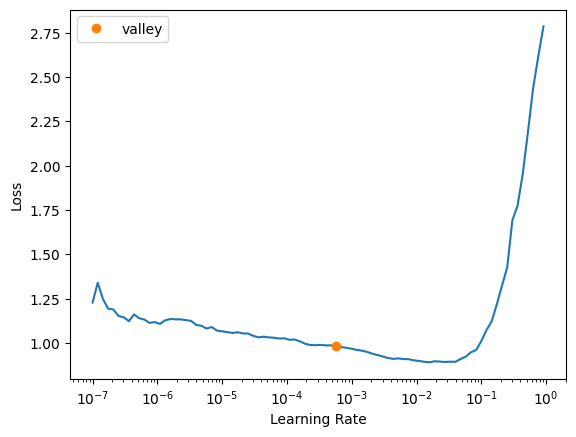

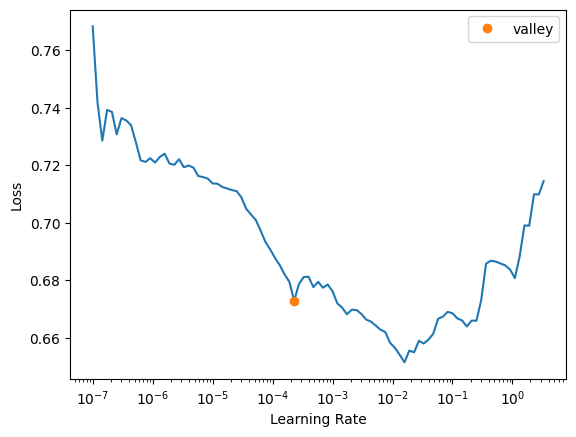

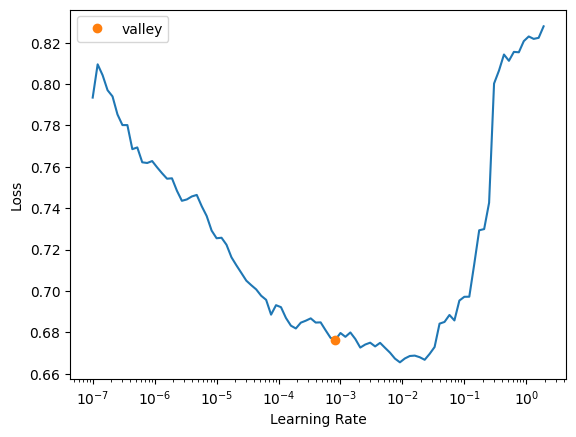

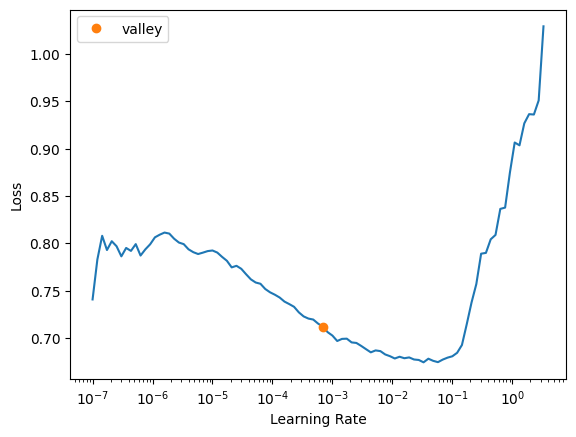

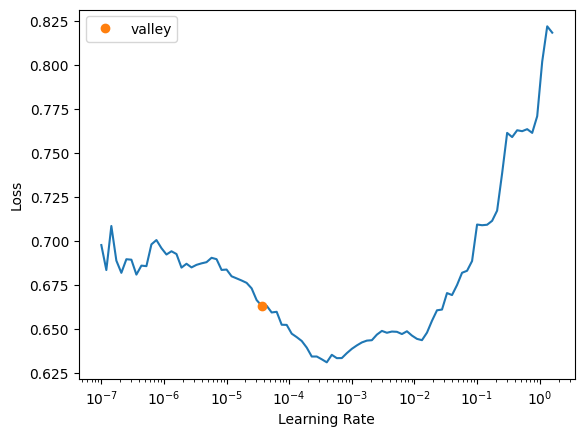

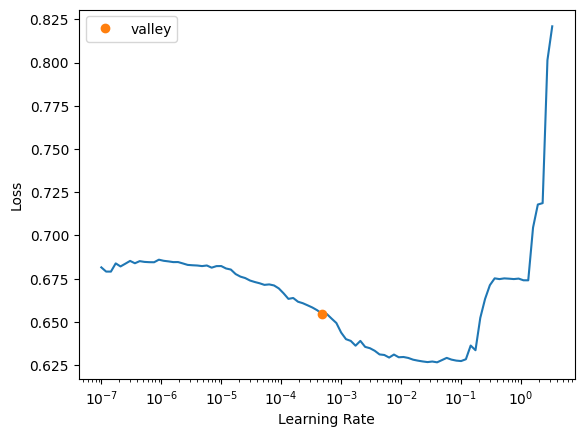

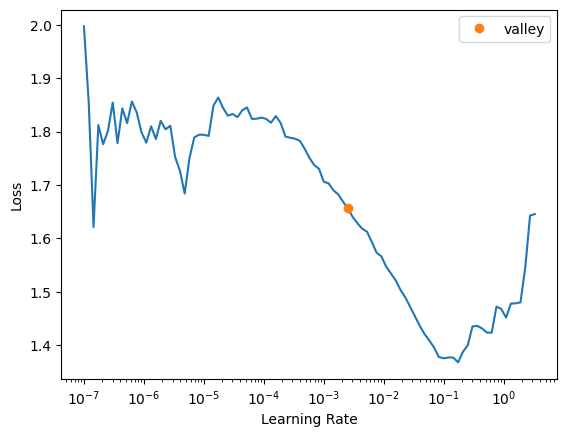

In [91]:
#InceptionTimeplus
import optuna
from optuna.integration import FastAIPruningCallback

# Define the number of epochs and Optuna trials
num_epochs = 5
num_optuna_trials = 100

# Define the objective function
def objective(trial: optuna.Trial):
    # Define the search space
    num_filters = trial.suggest_categorical("num_filters", [32, 64, 96, 128])
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 1.0)

    # Create model and learner
    model = InceptionTimePlus(dls.vars, dls.c, nf=num_filters, fc_dropout=dropout_rate)
    learn = Learner(dls, model, metrics=[accuracy, Precision(), Recall(), F1Score()])
    
    # Train the model
    learn.fit_one_cycle(num_epochs, lr_max=learn.lr_find())

    # Return the validation loss
    return learn.recorder.values[-1][1]

# Create an Optuna study
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.HyperbandPruner())

# Optimize the study
study.optimize(objective, n_trials=num_optuna_trials, show_progress_bar=True)
